## **Incremental Active-Learning Approach**

In [1]:
# Installing required libraries

!pip install modAL-python --quiet
!pip install git+https://github.com/scikit-learn-contrib/forest-confidence-interval.git  --quiet
!pip install xgboost --quiet
!pip install ipython-autotime  --quiet
!pip install shap --quiet
!pip install mapie --quiet
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.6/178.6 kB 5.4 MB/s eta 0:00:00
time: 350 µs (started: 2024-12-20 19:43:27 +00:00)


In [13]:
import numpy as np
import pandas as pd

from modAL.models import ActiveLearner

import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import forestci as fci

import gdown

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from itertools import cycle
from timeit import default_timer as timer

import warnings
from collections import defaultdict

import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor

from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

import shap

import random
from scipy import stats

time: 4.12 ms (started: 2024-12-20 19:47:42 +00:00)


In [3]:
shap.initjs() # Initialize SHAP for later

time: 12.7 ms (started: 2024-12-20 19:46:08 +00:00)


## **Utility functions**

In [4]:
# Utility function for accessing and formating the input dataframes.
# Dataframe df is assumed to be preprocessed already
def get_regression_data(df, target, cols=None, # Target columns
                        tactics=True, embeddings=True, # Flags to select tactic encoding, embeddings encoding, or both
                        split_by_level=True): # If True, the dataset is split into batches (for active learning)
  '''Prepares data for regression tasks.

  This function extracts features and target variables from a dataframe,
  optionally splitting the data into batches for active learning.

  Args:
    df: The input dataframe containing features and target variables.
    target: A list of column names representing the target variables.
    cols: A list of column names to include as features (default: None).
    tactics: A boolean flag indicating whether to include tactic encoding features (default: True).
    embeddings: A boolean flag indicating whether to include embeddings encoding features (default: True).
    split_by_level: A boolean flag indicating whether to split the data into batches based on the 'level' column (default: True).

  Returns:
    A tuple containing:
      - X_list: A list of feature matrices, or a single feature matrix if split_by_level is False.
      - y_list: A list of target variable arrays, or a single target variable array if split_by_level is False.
      - fnames: A list of feature names.
  '''

  if cols is None:
    cols = target
  temp = df.columns
  cols = cols+['solID']
  for t in target:
    if t in cols:
      cols.remove(t)
  if 'bot' in temp:
    cols.append('bot')
  if not tactics:
    tactic_cols = [c for c in temp if c.startswith('op')]
    for c in tactic_cols:
      cols.append(c)
  if not embeddings:
    emb_cols = [c for c in temp if c.startswith('emb')]
    for c in emb_cols:
      cols.append(c)

  X = df.drop(cols, axis=1)
  if len(target) == 1:
    y = df[target[0]]
  else:
    y = df[target]

  if split_by_level:
    levels = set(X['level'])
    X_list = []
    y_list = []
    for l in levels:
      #print(l)
      df_level = X[X['level'] == l]
      X_list.append(df_level.drop(['level']+target, axis=1).values)
      y_list.append(df_level[target].values)
  else:
    X_list = X.drop(['level']+target, axis=1).values
    if len(target) == 1:
      y_list = X[target[0]].values
    else:
      y_list = X[target].values

  fnames = list(X.columns)
  fnames.remove('level')
  for t in target:
    fnames.remove(t)

  return X_list, y_list, fnames

# Divides a column (or range) in n bins
def get_bins(col, n, min_max=(None,None)):
    """Divides a column into bins.

    This function divides a column (or range) into n bins.
    It calculates the bin edges based on the unique values in the column
    and the specified number of bins.

    Args:
        col: The column (pandas Series) to be divided into bins.
        n: The number of bins to create.
        min_max: Tuple (min, max) representing the minimum and maximum values
                 for the bins. If None, the minimum and maximum values of the
                 column are used (default: (None, None)).

    Returns:
        A list of bin edges.
    """

    unique_values = sorted((set(col.values)))
    if min_max == (None,None):
        min_x = np.min(unique_values)
        max_x = np.max(unique_values)
    else:
        print("Using predefined limits",min_max)
        min_x = min_max[0]
        max_x = min_max[1]
    min_x = min_x - 0.1
    max_x = max_x + 0.1
    delta = (max_x - min_x)/n
    #print(min_x, max_x, delta)
    return ([min_x+i*delta for i in range(0,n)] + [max_x])

# Utility function for plotting the distribution of the quality-attribute objectives (regression targets)
def plot_outcome_distribution(df_outcomes, n_bins=100, labels=5, filename=None, mins_maxs=(None,None),
                              colors=['blue', 'red', 'green', 'orange'], figsize=(8,8)):
    """Plots the distribution of quality-attribute objectives.

    This function creates a histogram to visualize the distribution of
    quality-attribute objectives (regression targets) in a given dataframe.
    It allows for customization of the number of bins, labels, and colors.
    The plot can be saved to a file if a filename is provided.

    Args:
        df_outcomes: Dataframe containing the quality-attribute objectives.
        n_bins: The number of bins for the histogram (default: 100).
        labels: The number of labels to display on the x-axis (default: 5).
        filename: The filename to save the plot to (default: None).
        mins_maxs: A list or tuple of (min, max) values to define the range of the x-axis for each subplot. If None, the minimum and maximum values of the column are used (default: (None, None)).
        colors: A list of colors to use for the histograms (default: ['blue', 'red', 'green', 'orange']).
        figsize: The size of the figure (default: (8, 8)).
    """

    qas = list(df_outcomes.columns)

    fig, axs = plt.subplots(len(qas), 1, sharey=True, tight_layout=True, figsize=figsize)
    for idx, qa in enumerate(qas):
        col = df_outcomes[qa]
        min_max = (None,None)
        if mins_maxs != (None,None):
            min_max = mins_maxs[idx]
            #print(min_max)
        col_range = get_bins(col, labels, min_max)
        print(qa, col_range)
        if min_max != (None,None):
            col = col.tolist()
            col.append(min_max[0])
            col.append(min_max[1])
        axs[idx].hist(col, bins=n_bins, color=colors[idx])
        axs[idx].set_title(qa)
        for xc in col_range:
            axs[idx].axvline(x=xc, color='gray', linestyle='dashed')

    if filename is not None:
        plt.savefig(filename)
    plt.show()

time: 11.7 ms (started: 2024-12-20 19:46:12 +00:00)


In [5]:
def compute_regression_metrics(y, y_pred):
  """Computes regression metrics.

  This function calculates common regression metrics to evaluate the
  performance of a regression model.

  Args:
      y: The true target values.
      y_pred: The predicted target values.

  Returns:
      A dictionary containing the computed metrics:
          - R2: R-squared (coefficient of determination)
          - MSE: Mean squared error
          - RMSE: Root mean squared error
          - MAE: Mean absolute error
          - MAPE: Mean absolute percentage error
  """

  metrics = dict()

  metrics['R2'] = r2_score(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  metrics['MSE'] = mse
  metrics['RMSE'] = np.sqrt(mse)
  metrics['MAE'] = mean_absolute_error(y, y_pred)
  metrics['MAPE'] = mean_absolute_percentage_error(y, y_pred)

  return metrics

# Creates a grid of charts showing the prediction errors of a regression (actual versus predicted values)
# The charts also include some regression metrics (e.g., R2, RMSE, MAE, MAPE)
# Optionally, specific values can be marked with stars (e.g., for distinguishing the sub-sampling strategy)
# Plots can be saved to a file
def show_prediction_errors_multioutput(y, y_pred, target, colors=['blue'], y_query=None, y_query_pred=None,
                                       metrics=True, x=1, verbose=True, title=None,
                                       gridsize=(1,4), errors=None, filename=None):
  """Creates a grid of charts showing prediction errors for multi-output regression.

    This function visualizes the prediction errors of a regression model with
    multiple output variables. It displays actual vs. predicted values using
    scatter plots and includes regression metrics like R2, RMSE, MAE, and MAPE.
    Optionally, it can highlight specific data points and save the plots to a file.

    Args:
        y: The true target values (NumPy array).
        y_pred: The predicted target values (NumPy array).
        target: A list of target variable names.
        colors: A list of colors for the scatter plots (default: ['blue']).
        y_query: Optional true target values for specific data points to highlight (default: None).
        y_query_pred: Optional predicted target values for specific data points to highlight (default: None).
        metrics: A boolean flag indicating whether to display regression metrics (default: True).
        verbose: A boolean flag indicating whether to print detailed metrics (default: True).
        title: An optional title for the plot (default: None).
        gridsize: A tuple specifying the number of rows and columns in the plot grid (default: (1, 4)).
        errors: Optional error bars for highlighted data points (default: None).
        filename: An optional filename to save the plot to (default: None).
  """

  for idx, n in enumerate(target):
    if verbose:
      print("-->", n)
      metrics = compute_regression_metrics(y[:,idx], y_pred[:,idx])
      for m in metrics.keys():
        print(m+"=", metrics[m])
  if verbose:
    print()

  n = len(target)
  fig, axs = plt.subplots(nrows=gridsize[0], ncols=gridsize[1], figsize=(4*gridsize[1], 4*gridsize[0]))
  for idx, n in enumerate(target):
    if len(colors) == 1:
      c = colors[0]
    else:
      c = colors[idx]
    j = idx % gridsize[1]
    i = idx // gridsize[1]
    #print("ax:", idx, i, j)
    if gridsize[0] == 1:
      ax = axs[j]
    else:
      ax = axs[i][j]
    PredictionErrorDisplay.from_predictions(
      y_true=y[:,idx],
      y_pred=y_pred[:,idx],
      kind="actual_vs_predicted",
      subsample=None,
      ax=ax, #axs[idx], #ax=axs[0][idx],
      random_state=0, scatter_kwargs={"alpha": 0.5, "color": c}
    )

    ax.set_title(n)
    if y_query is not None:
      if errors is not None:
        ax.errorbar(y_query_pred[:,idx], y_query[:,idx], yerr=errors, fmt="o", ecolor="gray", capsize=3, alpha=0.5)
      ax.scatter(y_query_pred[:,idx], y_query[:,idx], c='red', marker='*', s=80, alpha=0.5)

    # Add the score in the legend of each axis
    metrics = compute_regression_metrics(y[:,idx], y_pred[:,idx])

    r2_patch = mpatches.Patch(color='none', label='R2='+str(round(metrics['R2'], 2)))
    rmse_patch = mpatches.Patch(color='none', label='RMSE='+str(round(metrics['RMSE'], 2)))
    mae_patch = mpatches.Patch(color='none', label='MAE='+str(round(metrics['MAE'], 2)))
    mape_patch = mpatches.Patch(color='none', label='MAPE='+str(round(metrics['MAPE'], 2)))
    m_patches = [r2_patch, rmse_patch, mae_patch, mape_patch]
    if metrics:
      ax.legend(handles=m_patches)

  if filename is not None:
    plt.tight_layout()
    plt.savefig(filename, format='pdf')
  if title is not None:
    fig.suptitle(title)
  if filename is None:
    plt.tight_layout()
  plt.show()

time: 2.97 ms (started: 2024-12-20 19:46:25 +00:00)


In [6]:
def show_shap_plots(X, fnames, model, targets):
  """Displays SHAP bar plots for feature importance.

  This function utilizes the SHAP (SHapley Additive exPlanations) library to
  calculate and visualize the importance of features in a prediction model.
  It generates bar plots showing the impact of each feature on the model's output.

  Args:
      X: The input data (NumPy array or Pandas DataFrame).
      fnames: A list of feature names corresponding to the columns in X.
      model: The trained prediction model.
      targets: A list of target variable names.
  """

  df = pd.DataFrame(X, columns=fnames)
  explainer = shap.Explainer(model)
  shap_values = explainer(df)
  for i in range(shap_values.shape[2]):  # If shap_values is for multiple outputs
    print("Target:", targets[i])
    output_shap_values = shap_values[:, :, i]
    shap.plots.bar(output_shap_values, max_display=15)

time: 977 µs (started: 2024-12-20 19:46:36 +00:00)


## **Load datasets**

In [7]:
# Datasets are assumed to be already pre-processed/encoded

STPLUS_URL = "https://drive.google.com/uc?export=download&id=16djDub7k7IFNrt-m2AGrdnaiL-Z0dk4Q"
STPLUS_DATAPATH = 'stplus-levels-bots-features.csv'

COCOME_URL = "https://drive.google.com/uc?export=download&id=184kCSqcc03BngNSr-UY0ejzK1q0csMqp"
COCOME_DATAPATH = 'cocome-levels-features.csv'

OBJ_STPLUS= ['m1', 'm2', 'p1', 'p2']
OBJ_COCOME = ['m1', 'm2', 'm3', 'm4','p1', 'p2', 'p3', 'p4']

print(gdown.download(STPLUS_URL, STPLUS_DATAPATH, quiet=True))
print(gdown.download(COCOME_URL, COCOME_DATAPATH, quiet=True))

stplus-levels-bots-features.csv
cocome-levels-features.csv
time: 8.43 s (started: 2024-12-20 19:46:40 +00:00)


In [8]:
df_stplus = pd.read_csv(STPLUS_DATAPATH, index_col=0)
print(df_stplus.shape)
df_stplus.head() # raw ST+ dataset

(454, 741)


,solID,m1,m2,p1,p2,level,bot,op1_mod-split(PaymentSystem)-wrapper(IBooking),op1_mod-split(PaymentSystem)-wrapper(IBusinessTrip),op1_mod-split(PaymentSystem)-wrapper(IEmployeePayment),...,emb_490_0,emb_491_0,emb_492_0,emb_493_0,emb_494_0,emb_495_0,emb_496_0,emb_497_0,emb_498_0,emb_499_0
0,sol-arch_270,115.0,291.5,24.37365,29.9622,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sol-arch_81,119.0,110.5,14.12836,21.8758,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sol-arch_103,115.0,190.5,18.76987,33.9213,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sol-arch_508,119.0,231.5,16.93228,26.7557,2,Performance,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sol-arch_182,115.0,190.5,21.48976,26.6179,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 129 ms (started: 2024-12-20 19:46:50 +00:00)


In [9]:
df_cocome = pd.read_csv(COCOME_DATAPATH, index_col=0)
print(df_cocome.shape)
df_cocome # raw CoCoME dataset

(1192, 929)


,solID,m1,m2,m3,m4,p1,p2,p3,p4,level,...,emb_490_0,emb_491_0,emb_492_0,emb_493_0,emb_494_0,emb_495_0,emb_496_0,emb_497_0,emb_498_0,emb_499_0
0,sol-arch_1004,2218.0,727.0,137.5,2172.5,0.897089,1.071037,1.025776,1.901695,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sol-arch_401,2333.0,750.5,161.0,2216.5,1.298680,1.550426,1.706878,2.576643,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sol-arch_137,2262.0,731.5,142.0,2216.5,0.976805,1.124319,1.214135,1.853881,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sol-arch_453,2333.0,798.0,208.5,2216.5,1.052553,1.226608,1.160202,2.045067,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sol-arch_404,2333.0,798.0,208.5,2216.5,1.052553,1.226608,1.160202,2.045067,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,sol-arch_1174,2289.0,802.5,204.0,2172.5,0.832682,0.937078,1.117719,1.435772,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1188,sol-arch_187,2289.0,802.5,181.0,2172.5,1.233312,1.676923,1.305529,3.288065,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1189,sol-arch_674,2289.0,802.5,208.5,2172.5,0.965911,1.173523,0.926582,2.053899,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1190,sol-arch_821,2261.0,730.5,142.0,2215.5,1.031333,1.187748,1.737787,2.023827,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 246 ms (started: 2024-12-20 19:46:53 +00:00)


In [10]:
# Show distribution of quality-attribute objectives for ST+
scaler = StandardScaler() # Objectives are first standardized using Z-score method
scaled_stplus_df = pd.DataFrame(scaler.fit_transform(df_stplus[OBJ_STPLUS]), columns=OBJ_STPLUS)
# make_boxplots(scaled_stplus_df, title='STPlus (scaled)', figsize=(400, 900))

time: 26.1 ms (started: 2024-12-20 19:47:00 +00:00)


In [11]:
# Show distribution of quality-attribute objectives for CoCoME
scaler = StandardScaler() # Objectives are first standardized using Z-score method
scaled_cocome_df = pd.DataFrame(scaler.fit_transform(df_cocome[OBJ_COCOME]), columns=OBJ_COCOME)
# make_boxplots(scaled_cocome_df, title='CoCoME (scaled)', figsize=(400, 1600))

time: 14.2 ms (started: 2024-12-20 19:47:04 +00:00)


## **Experiments with the dataset arranged in batches**

In [12]:
warnings.filterwarnings('ignore')

time: 638 µs (started: 2024-12-20 19:47:32 +00:00)


In [14]:
# Implementation of CV+ strategy for regressors (RF or XGBoost)
# It returns the instances of X with the largest prediction error (uncertainty)
def mapie_regression_std(estimator, X_test, X_train, y_train, targets, k=20, random_selection=False): #, alpha=0.05, cv=10):

  """Implements the CV+ strategy for regression uncertainty estimation.

  This function uses the MAPIE (Model Agnostic Prediction Interval Estimator) library
  to estimate prediction intervals for regression models. It specifically implements the
  Conformalized Quantile Regression (CQR) method with the 'plus' strategy (CV+).
  It identifies the instances in X_test with the largest prediction errors (uncertainty)
  based on the estimated prediction intervals.

  Args:
      estimator: The trained regression model (e.g., RandomForestRegressor, XGBRegressor).
      X_test: The feature matrix for the test set.
      X_train: The feature matrix for the training set.
      y_train: The target variable array for the training set.
      targets: A list of target variable names.
      k: The number of instances to select with the largest prediction errors (default: 20).
      random_selection: If True, select indices randomly (default: False)

  Returns:
      A tuple containing:
          - indices: The indices of the k instances in X_test with the largest prediction errors.
          - total_errors: The prediction errors for all instances in X_test.
  """

  errors_df = pd.DataFrame()
  for idx, t in enumerate(targets):
    # model = estimator.estimator
    model = sklearn.base.clone(estimator.estimator)
    mapie_regressor = MapieRegressor(estimator=model, method='plus', cv=10)
    mapie_regressor = mapie_regressor.fit(X_train, y_train[:,idx])
    _, y_pis_idx = mapie_regressor.predict(X_test, alpha=0.05)
    bounds = [(x[0][0], x[1][0]) for x in y_pis_idx]
    error_idx = [(sup-inf) for (inf, sup) in bounds]
    errors_df[t] = error_idx

  # total_errors = errors_df.sum(axis=1).to_numpy()
  total_errors = errors_df.max(axis=1).to_numpy()
  if not random_selection:
    indices = np.argpartition(total_errors, -k)[-k:] # Indices of the values with highest predicted errors
  else: # Alternatively, indices can be selected randomly
    print("Selecting indices at random!")
    random.seed(14)
    indices = random.sample(range(len(total_errors)), k)
  return indices, total_errors


time: 8.27 ms (started: 2024-12-20 19:47:56 +00:00)


In [15]:
# Implementation of sub-sampling strategy for RF regressor (it doesn't work for XGBoost)
# It returns the instances of X with the largest prediction error
# Prediction errors are estimated using fci library
def rf_regression_std(estimator, X, x_shape, target, y_pred, k=20, calibration=True):

  """Estimates prediction errors for a RandomForestRegressor using the forestci library.

  This function calculates prediction errors for a RandomForestRegressor model
  using the `forestci` library. It estimates the variance of predictions and
  identifies the instances in X with the largest prediction errors (uncertainty).
  It is specifically designed for RandomForestRegressor and may not be suitable for other models.

  Args:
      estimator: The trained RandomForestRegressor model.
      X: The feature matrix for which to estimate prediction errors.
      x_shape: The shape of the original training data's feature matrix.
      target: A list of target variable names.
      y_pred: The predicted target values.
      k: The number of instances to select with the largest prediction errors (default: 20).
      calibration: A boolean flag indicating whether to calibrate the prediction errors
                   (default: True). Calibration can improve the accuracy of error estimates.

  Returns:
      A tuple containing:
          - indices: The indices of the k instances in X with the largest prediction errors.
          - total_error: The estimated prediction errors for all instances in X.
  """

  #print("calibration enabled?", calibration, x_shape)
  total_error = np.zeros(X.shape[0])
  # Initialize a list to store the worst errors for each target variable
  worst_errors = []
  for idx in range(len(target)):
    error = fci.random_forest_error(estimator.estimator, x_shape, X, calibrate=calibration, inbag=None, y_output=idx)
    total_error = np.sum([total_error, abs(error)], axis=0) # If calibration is False, errors could have negative values
    # Store the largest error for the current target variable
    # worst_errors.append(np.max(error))  # Append the largest error to the list

  # Combine the worst errors into a single array
  # total_error = np.array(worst_errors)

  indices = np.argpartition(total_error, -k)[-k:] # Indices of the values with highest predicted errors
  return indices, total_error

time: 1.9 ms (started: 2024-12-20 19:48:00 +00:00)


In [16]:
# It runs the whole dataset divided into batched, and applies a RF regressor on each batch
def run_active_learning_batches(X_batches, y_batches, regressor, n_queries=0.2, show_plots=None, target=None,
                                calibration=True, verbose=True, scale_y=True, show_errors=False, filename=None):
  """Executes active learning on data divided into batches.

  This function implements an active learning loop using data organized in batches.
  It iteratively trains a regressor on an initial batch and then selects the most
  informative instances from subsequent batches to add to the training set.
  It uses a query strategy to identify these instances, aiming to improve model
  performance with fewer labeled data points. The function also provides options for
  visualizing prediction errors, scaling the target variable, and controlling the level
  of detail in the output.

  Args:
      X_batches: A list of feature matrices, each representing a batch of data.
      y_batches: A list of target variable arrays corresponding to the feature matrices in X_batches.
      regressor: The regression model to use (e.g., RandomForestRegressor, XGBRegressor).
      n_queries: The proportion or number of instances to query from each batch (default: 0.2).
      show_plots: A tuple specifying the grid size for prediction error plots (e.g., (1, 4)). If None, plots are not shown.
      target: A list of target variable names.
      calibration: A boolean flag indicating whether to calibrate prediction errors (default: True).
      verbose: A boolean flag indicating whether to print detailed metrics (default: True).
      scale_y: A boolean flag indicating whether to scale the target variable using StandardScaler (default: True).
      show_errors: A boolean flag indicating whether to show error bars in prediction error plots (default: False).
      filename: An optional filename to save the final prediction error plot to (default: None).

  Returns:
      A tuple containing:
          - dict_metrics: A dictionary containing the computed regression metrics for each batch and the overall results.
          - y_pred_flat: The predicted target values for all instances in all batches, concatenated into a single array.
  """

  dict_metrics = defaultdict(list)
  start = timer()

  if scale_y:
    print("standard scaling y ...", len(y_batches))
    scaler = StandardScaler()
    for i in range(len(y_batches)):
      y_batches[i] = scaler.fit_transform(y_batches[i])

  print('max', n_queries, 'percentage - queries')
  y_pred_batches = []

  print('='*10)
  X1 = X_batches[0]
  y1 = y_batches[0]
  k = X1.shape[0]
  #print(k)

  # Assembling initial training set (level 1)
  print('Batch 0:', X1.shape, y1.shape)
  n1 = y1.shape[0]
  n_oracle = n1
  dict_metrics['exp'] = dict_metrics['exp'] + ['incremental - batch 0']
  dict_metrics['size'] = dict_metrics['size'] + [X1.shape[0]]
  dict_metrics['features'] = dict_metrics['features'] + [X1.shape[1]]
  dict_metrics['queries'] = dict_metrics['queries'] + [n1]

  start1 = timer()
  # initializing the active learner (level 1)
  query_strategy = mapie_regression_std # mapie_regression_std # rf_regression_std
  learner = ActiveLearner(bootstrap_init=True,
    estimator=regressor, query_strategy=query_strategy,
    X_training=X1, y_training=y1
  )

  y_pred1 = learner.predict(X1)
  y_pred_batches.append(y_pred1)

  end1 = timer()
  elapsed_time1 = end1 - start1
  dict_metrics['time'] = dict_metrics['time'] + [elapsed_time1]

  # plotting the initial estimation (level 1)
  title = 'Batch 0: Initial training with {0} points - {1} instances'.format(n1, n1)
  print(title)
  print("Regressor score=%.2f " % regressor.score(X1, y_pred1))
  print()
  if show_plots is not None:
    show_prediction_errors_multioutput(y1, y_pred1, target=target, colors=['red'],
                                       title=title, verbose=verbose, gridsize=show_plots)
    print()

  print("Initial metrics:")
  metrics = compute_regression_metrics(y1, y_pred1)
  for m in metrics.keys():
    dict_metrics[m] = dict_metrics[m] + [metrics[m]]
    print(m+"=", metrics[m])

  # Iterations of incremental/active learning
  x_shape = X1.shape
  for i in range(1,len(X)):
    print()
    print('='*10)
    # active learning
    start1 = timer()

    X2 = X_batches[i]
    y2 = y_batches[i]
    print('Batch ',i,':', X2.shape, y2.shape)
    n2 = y2.shape[0]
    dict_metrics['exp'] = dict_metrics['exp'] + ['incremental - batch '+str(i)]
    dict_metrics['size'] = dict_metrics['size'] + [X2.shape[0]]
    dict_metrics['features'] = dict_metrics['features'] + [X2.shape[1]]

    query_list = []
    count_queries = round(n_queries*n2)
    print('max', count_queries, 'queries')
    dict_metrics['queries'] = dict_metrics['queries'] + [count_queries]
    y_pred1 = learner.predict(X2) # Initial prediction

    # query_idxs, query_instances, y_pred1_errors = learner.query(X2, x_shape, target, y_pred1, k=count_queries,
    #                                                             calibration=calibration, return_metrics=True)
    query_idxs, query_instances, y_pred1_errors = learner.query(X2, X1, y1, target, k=count_queries,
                                                                random_selection=True, return_metrics=True)
    #print("About to make batch query", len(query_idxs), len(y_pred1_errors))
    query_list.extend(query_idxs)
    learner.teach(X2[query_idxs], y2[query_idxs])
    print(n_queries, len(query_list), 'queries:', query_list)
    x_shape = X2.shape

    y_pred2 = learner.predict(X2)
    y_pred_batches.append(y_pred2)
    n_oracle += len(query_list)

    end1 = timer()
    elapsed_time1 = end1 - start1
    dict_metrics['time'] = dict_metrics['time'] + [elapsed_time1]

    title = 'Batch {0}: Adjusted after {1} queries - {2} instances'.format(i, len(query_list), n2)
    print(title)
    print()

    if show_plots:
      y_query = y2[query_list]
      y_query_pred = y_pred1[query_list] #y_pred2[query_list]
      y_query_errors = None
      if show_errors:
        y_query_errors = y_pred1_errors[query_idxs]
      show_prediction_errors_multioutput(y2, y_pred1, title=title, y_query=y_query, y_query_pred=y_query_pred,
                                         verbose=verbose, target=target, colors=['cyan'], gridsize=show_plots,
                                         errors=y_query_errors)
      print()
      y_query_pred = y_pred2[query_list]
      show_prediction_errors_multioutput(y2, y_pred2, target=target, y_query=y_query, y_query_pred=y_query_pred,
                                         title=title, verbose=verbose, gridsize=show_plots)
      print()

    print("Adjusted metrics:")
    metrics = compute_regression_metrics(y2, y_pred2)
    for m in metrics.keys():
      dict_metrics[m] = dict_metrics[m] + [metrics[m]]
      print(m+"=", metrics[m])

  print()
  end = timer()
  elapsed_time = end - start
  print("Elapsed time:", elapsed_time, "seconds") # Time in seconds
  dict_metrics['time'] = dict_metrics['time'] + [elapsed_time]

  print()
  print('='*10)
  y_flat = np.array([item for sublist in y_batches for item in sublist])
  y_pred_flat = np.array([item for sublist in y_pred_batches for item in sublist])
  #print(type(y_pred_flat), y_pred_flat)
  title = 'All batches: Results with {0} queries - {1} instances'.format(n_oracle, len(y_flat))
  print("oracle evaluation:", n_oracle, '(out of', len(y_flat),'points)')
  if show_plots:
    show_prediction_errors_multioutput(y_flat, y_pred_flat, target=target, colors=['green'], title=title,
                                       gridsize=show_plots, filename=filename)

  dict_metrics['exp'] = dict_metrics['exp'] + ['incremental - all']
  dict_metrics['size'] = dict_metrics['size'] + [len(y_flat)]
  dict_metrics['features'] = dict_metrics['features'] + [X1.shape[1]]
  dict_metrics['queries'] = dict_metrics['queries'] + [n_oracle]
  metrics = compute_regression_metrics(y_flat, y_pred_flat)
  for m in metrics.keys():
    dict_metrics[m] = dict_metrics[m] + [metrics[m]]
    print(m+"=", metrics[m])

  return dict_metrics, y_pred_flat

time: 3.48 ms (started: 2024-12-20 19:48:04 +00:00)


### **STPlus results**
Test the 3 available configurations for the encodings, using the IAL approach

STPLUS - tactics only
levels 2 2
(30, 234) (30, 4)
standard scaling y ... 2
max 0.25 percentage - queries
Batch 0: (30, 234) (30, 4)
Batch 0: Initial training with 30 points - 30 instances
Regressor score=1.00 



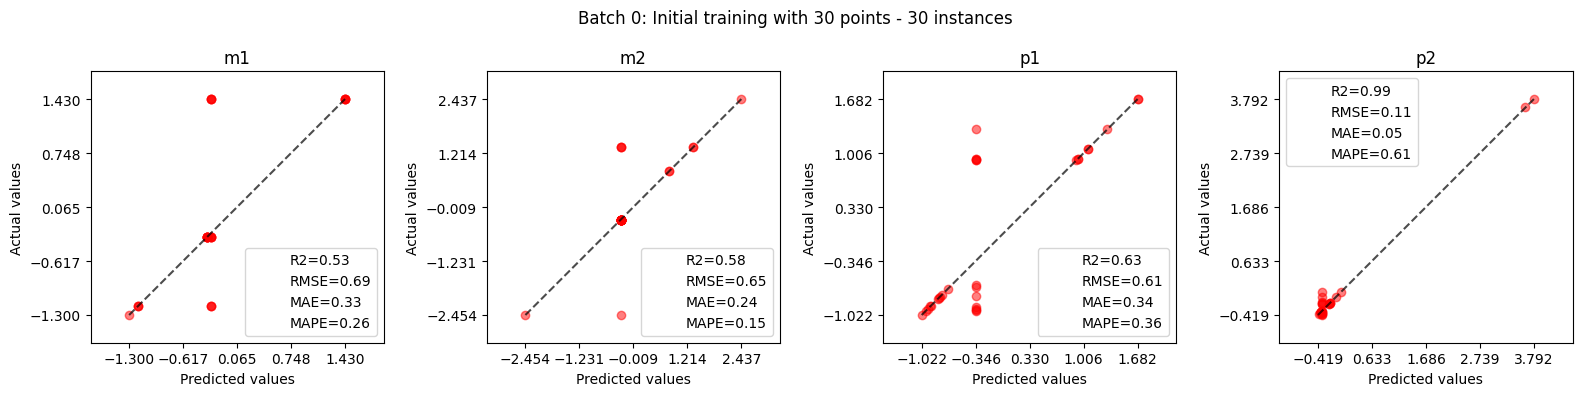


Initial metrics:
R2= 0.6819692831532277
MSE= 0.31803071684677225
RMSE= 0.5639421218944124
MAE= 0.23902035018304774
MAPE= 0.34587193958144935

Batch  1 : (424, 234) (424, 4)
max 106 queries
Selecting indices at random!
0.25 106 queries: [54, 315, 359, 386, 333, 269, 126, 138, 376, 130, 149, 375, 37, 337, 230, 155, 238, 350, 203, 201, 398, 60, 134, 114, 161, 183, 133, 184, 323, 395, 264, 76, 82, 282, 340, 339, 140, 84, 5, 419, 35, 62, 304, 172, 14, 42, 387, 104, 195, 206, 298, 224, 311, 48, 328, 351, 57, 296, 301, 326, 324, 186, 92, 370, 249, 263, 344, 99, 416, 231, 319, 111, 248, 144, 256, 414, 52, 382, 45, 142, 143, 402, 379, 391, 210, 58, 418, 300, 47, 217, 245, 86, 273, 197, 233, 158, 368, 235, 223, 213, 381, 360, 131, 242, 404, 120]
Batch 1: Adjusted after 106 queries - 424 instances



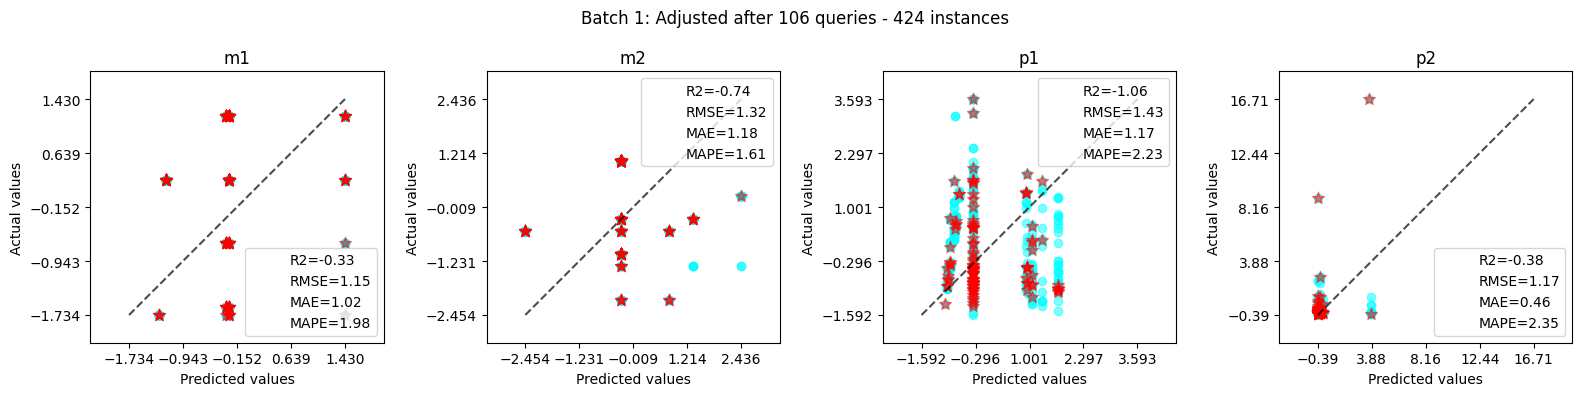

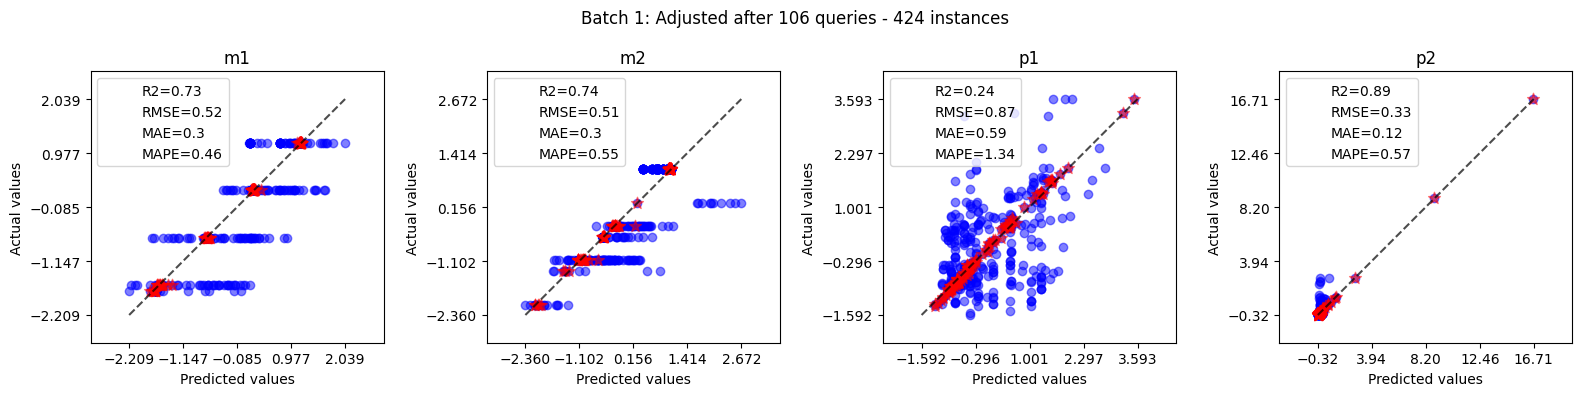


Adjusted metrics:
R2= 0.649158040178883
MSE= 0.35084195982111704
RMSE= 0.5923191368013675
MAE= 0.3284834902393638
MAPE= 0.727402375153161

Elapsed time: 5.963465051000014 seconds

oracle evaluation: 136 (out of 454 points)
--> m1
R2= 0.7122391298771653
MSE= 0.28776087012283474
RMSE= 0.5364334722245012
MAE= 0.3032548106564399
MAPE= 0.44799732706683626
--> m2
R2= 0.7313487197522315
MSE= 0.2686512802477687
RMSE= 0.5183158113040434
MAE= 0.29900517243361613
MAPE= 0.5197732424520061
--> p1
R2= 0.26317682896359973
MSE= 0.7368231710364
RMSE= 0.858384046354777
MAE= 0.5728397533732329
MAPE= 1.272143848332398
--> p2
R2= 0.8985400573580449
MSE= 0.1014599426419551
RMSE= 0.3185277737371658
MAE= 0.11518757954536032
MAPE= 0.5688500337116132



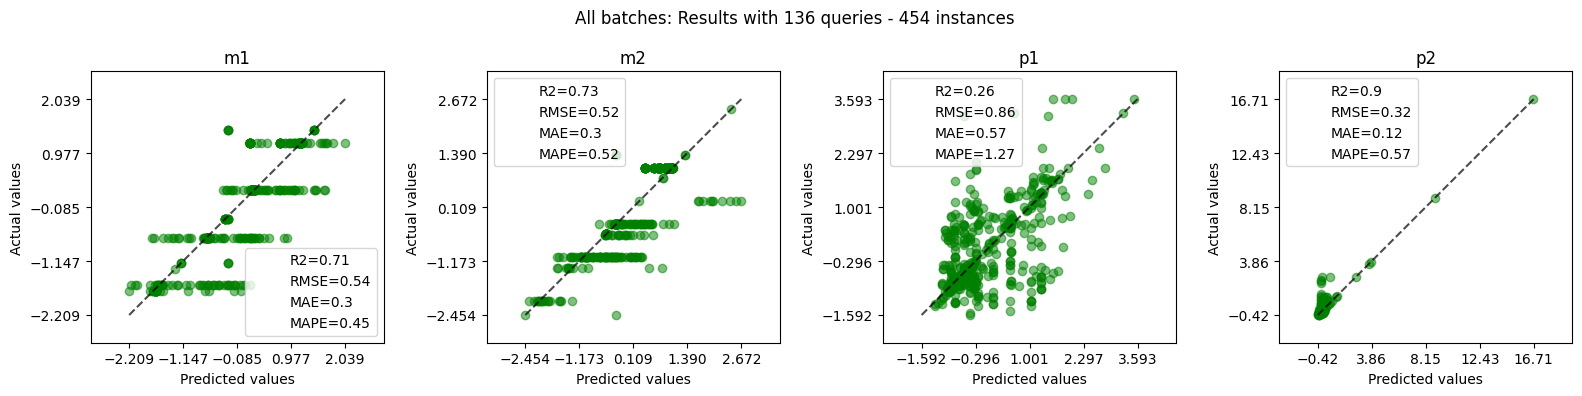

R2= 0.6513261839877608
MSE= 0.3486738160122396
RMSE= 0.5904860845204056
MAE= 0.3225718290021623
MAPE= 0.7021911128907132



,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE
0,incremental - batch 0,30,234,30,0.101823,0.681969,0.318031,0.563942,0.239020,0.345872
1,incremental - batch 1,424,234,106,2.436642,0.649158,0.350842,0.592319,0.328483,0.727402
2,incremental - all,454,234,136,5.963465,0.651326,0.348674,0.590486,0.322572,0.702191


time: 6.91 s (started: 2024-12-20 19:48:11 +00:00)


In [17]:
print ("STPLUS - tactics only")
target = OBJ_STPLUS
X, y, _ = get_regression_data(df_stplus, target=target, tactics=True, embeddings=False, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

# Number of queries (SF) needs to be set
metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=0.25, calibration=True, show_plots=(1,4),
                                      target=target, verbose=False, show_errors=False)

print()
pd.DataFrame(metrics)

STPLUS -  embeddings only
levels 2 2
(30, 500) (30, 4)
standard scaling y ... 2
max 0.25 percentage - queries
Batch 0: (30, 500) (30, 4)
Batch 0: Initial training with 30 points - 30 instances
Regressor score=1.00 



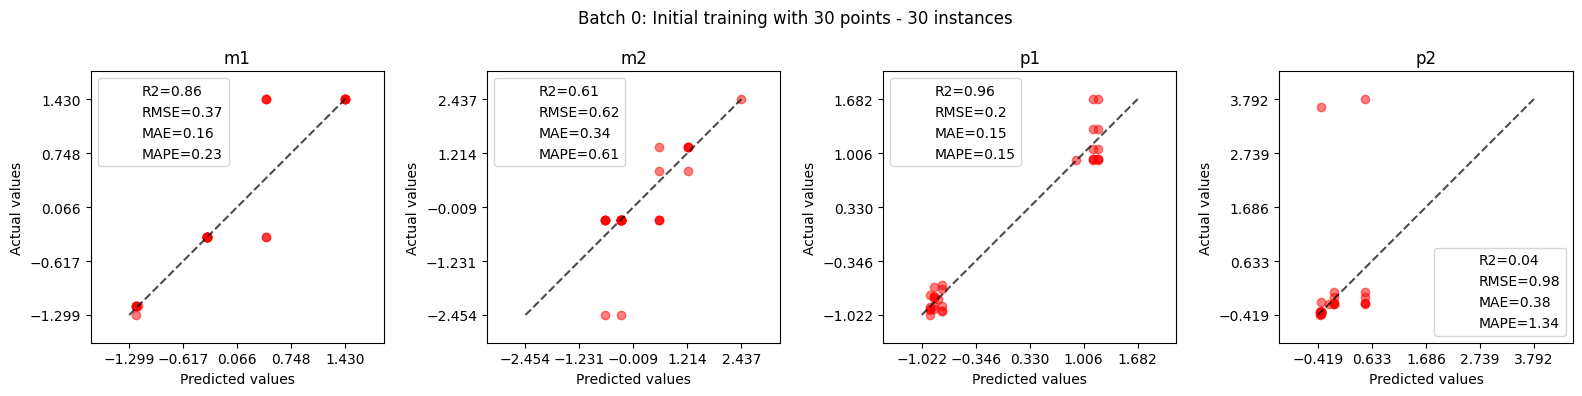


Initial metrics:
R2= 0.6186608183496249
MSE= 0.3813391816503751
RMSE= 0.6175266647282327
MAE= 0.25616276529437215
MAPE= 0.5829420777180905

Batch  1 : (424, 500) (424, 4)
max 106 queries
Selecting indices at random!
0.25 106 queries: [54, 315, 359, 386, 333, 269, 126, 138, 376, 130, 149, 375, 37, 337, 230, 155, 238, 350, 203, 201, 398, 60, 134, 114, 161, 183, 133, 184, 323, 395, 264, 76, 82, 282, 340, 339, 140, 84, 5, 419, 35, 62, 304, 172, 14, 42, 387, 104, 195, 206, 298, 224, 311, 48, 328, 351, 57, 296, 301, 326, 324, 186, 92, 370, 249, 263, 344, 99, 416, 231, 319, 111, 248, 144, 256, 414, 52, 382, 45, 142, 143, 402, 379, 391, 210, 58, 418, 300, 47, 217, 245, 86, 273, 197, 233, 158, 368, 235, 223, 213, 381, 360, 131, 242, 404, 120]
Batch 1: Adjusted after 106 queries - 424 instances



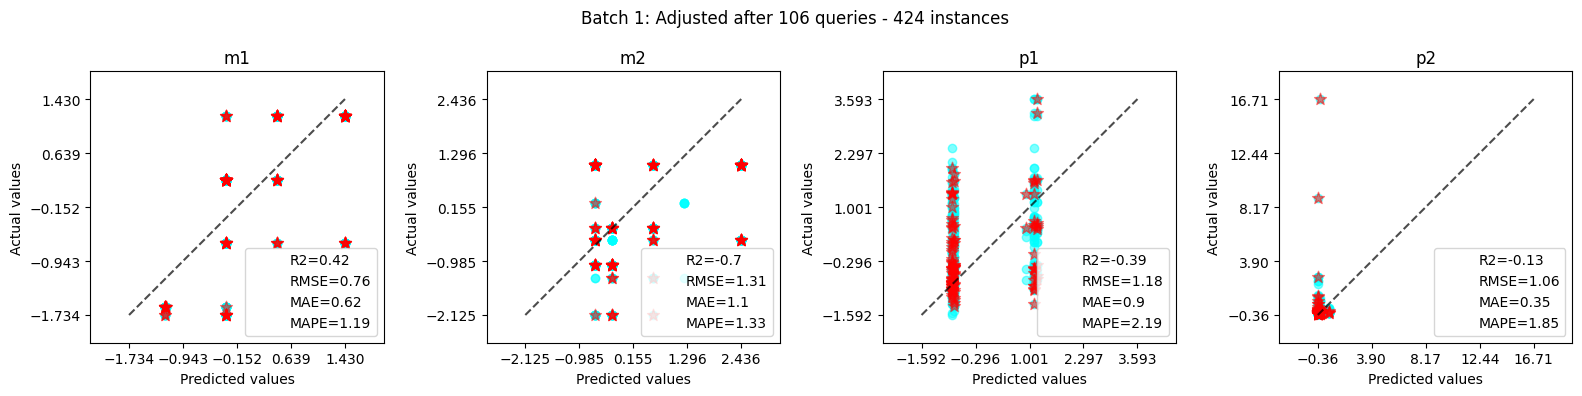

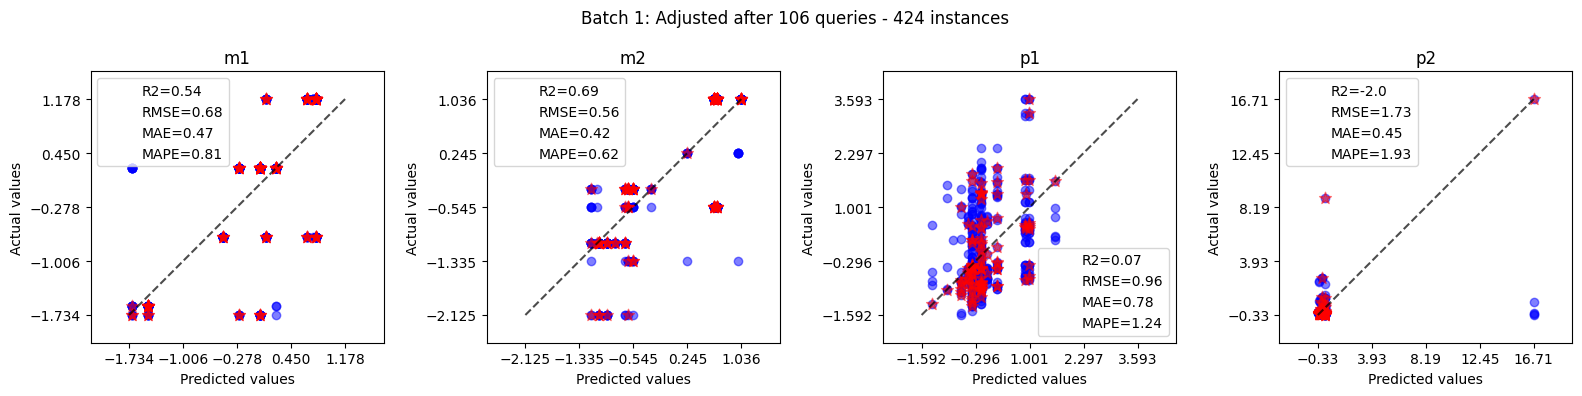


Adjusted metrics:
R2= -0.17566379837284413
MSE= 1.175663798372844
RMSE= 1.084280313559572
MAE= 0.5305500584344133
MAPE= 1.1486726630451667

Elapsed time: 5.585490464999964 seconds

oracle evaluation: 136 (out of 454 points)
--> m1
R2= 0.561498729961727
MSE= 0.4385012700382731
RMSE= 0.6621942842083984
MAE= 0.4510548138254234
MAPE= 0.7708946846563013
--> m2
R2= 0.6843206997961675
MSE= 0.31567930020383256
RMSE= 0.561853450824886
MAE= 0.4124689675718948
MAPE= 0.6157243735675946
--> p1
R2= 0.12873193654761428
MSE= 0.8712680634523855
RMSE= 0.9334174111577229
MAE= 0.7404108974170697
MAPE= 1.1665203881791186
--> p2
R2= -1.8672529166103313
MSE= 2.8672529166103304
RMSE= 1.6932964644770065
MAE= 0.4457402792034312
MAPE= 1.8920188924753378



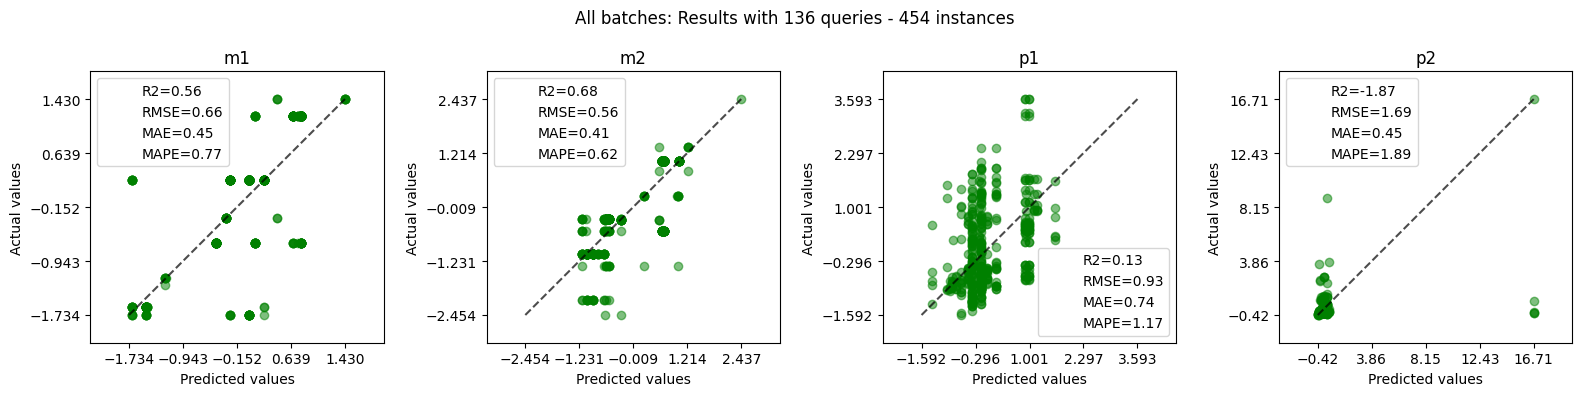

R2= -0.12317538757620417
MSE= 1.123175387576205
RMSE= 1.0597996921948056
MAE= 0.5124187395044546
MAPE= 1.111289584719589



,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE
0,incremental - batch 0,30,500,30,0.172736,0.618661,0.381339,0.617527,0.256163,0.582942
1,incremental - batch 1,424,500,106,2.444193,-0.175664,1.175664,1.084280,0.530550,1.148673
2,incremental - all,454,500,136,5.585490,-0.123175,1.123175,1.059800,0.512419,1.111290


time: 6.49 s (started: 2024-12-20 19:49:04 +00:00)


In [18]:
print ("STPLUS -  embeddings only")
target = OBJ_STPLUS
X, y, _ = get_regression_data(df_stplus, target=target, tactics=False, embeddings=True, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=0.25, calibration=True, show_plots=(1,4),
                                      target=target, verbose=False, show_errors=False)

print()
pd.DataFrame(metrics)

STPLUS - tactics & embeddings
levels 2 2
(30, 734) (30, 4)
standard scaling y ... 2
max 0.5 percentage - queries
Batch 0: (30, 734) (30, 4)
Batch 0: Initial training with 30 points - 30 instances
Regressor score=1.00 



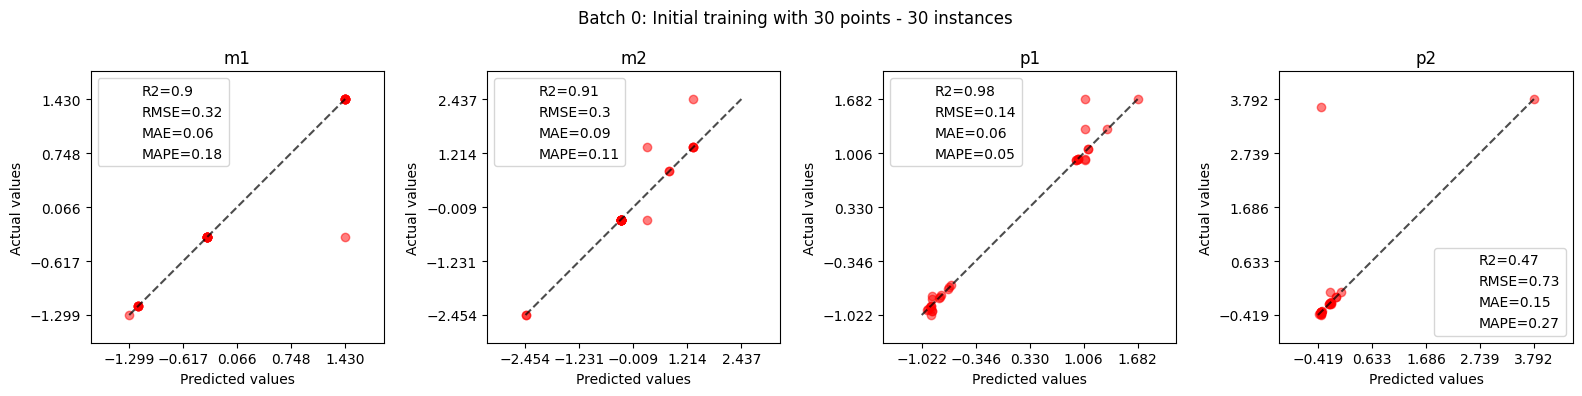


Initial metrics:
R2= 0.8142887438941707
MSE= 0.18571125610582928
RMSE= 0.43094228860234784
MAE= 0.08842675712198818
MAPE= 0.1516376801916745

Batch  1 : (424, 734) (424, 4)
max 212 queries
Selecting indices at random!
0.5 212 queries: [54, 315, 359, 386, 333, 269, 126, 138, 376, 130, 149, 375, 37, 337, 230, 155, 238, 350, 203, 201, 398, 60, 134, 114, 161, 183, 133, 184, 323, 395, 264, 76, 82, 282, 340, 339, 140, 84, 5, 419, 35, 62, 304, 172, 14, 42, 387, 104, 195, 206, 298, 224, 311, 48, 328, 351, 57, 296, 301, 326, 324, 186, 92, 370, 249, 263, 344, 99, 416, 231, 319, 111, 248, 144, 256, 414, 52, 382, 45, 142, 143, 402, 379, 391, 210, 58, 418, 300, 47, 217, 245, 86, 273, 197, 233, 158, 368, 235, 223, 213, 381, 360, 131, 242, 404, 120, 409, 422, 250, 34, 291, 73, 316, 136, 292, 225, 9, 207, 216, 10, 177, 313, 188, 241, 401, 182, 154, 271, 96, 21, 286, 240, 321, 322, 198, 50, 17, 98, 159, 12, 0, 259, 406, 267, 403, 128, 338, 287, 74, 101, 283, 117, 278, 349, 135, 93, 127, 106, 169, 413,

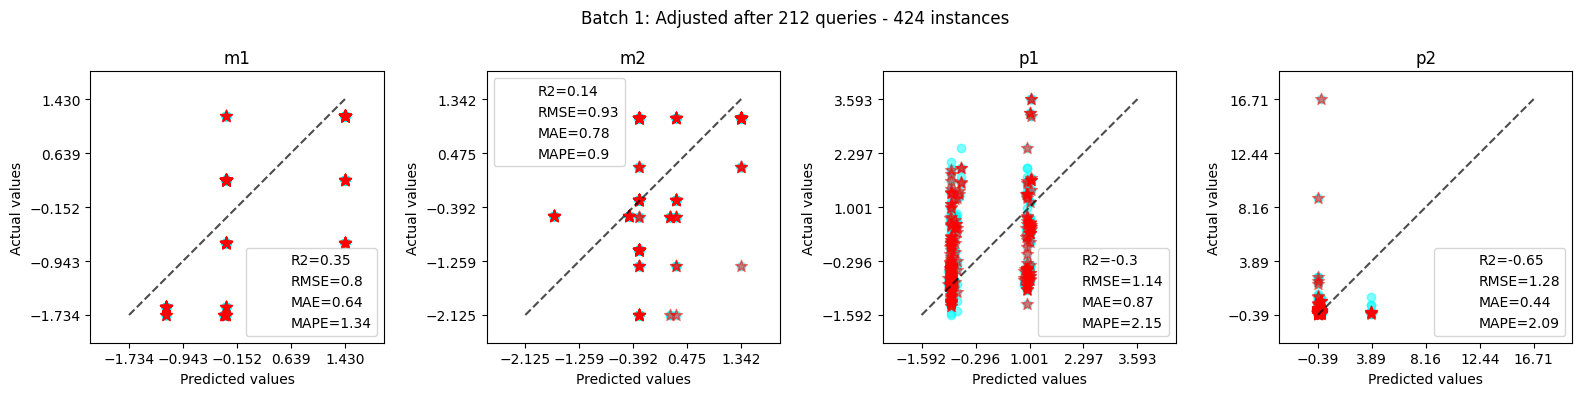

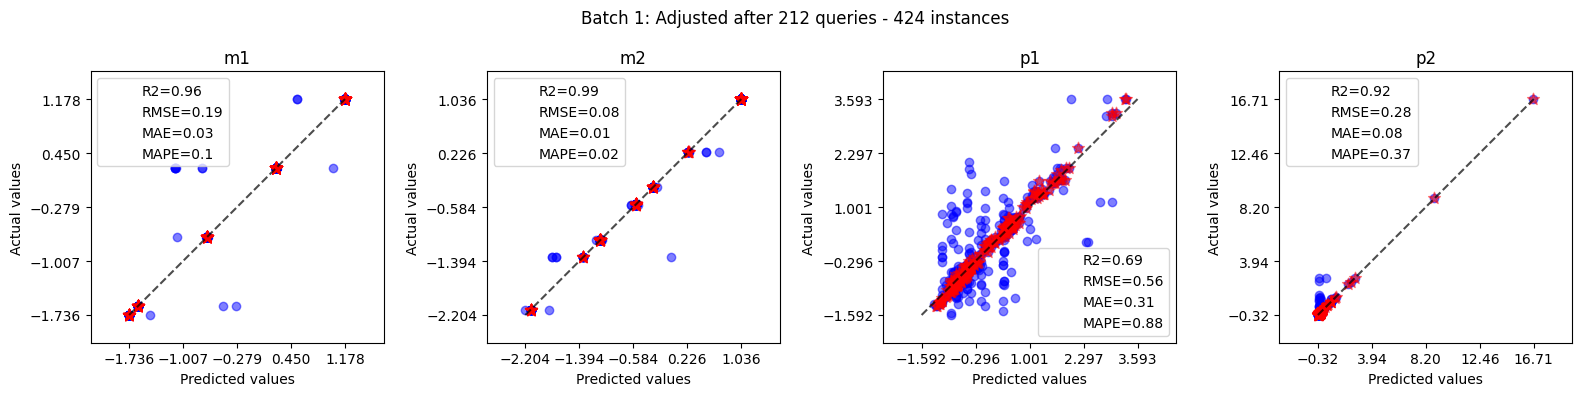


Adjusted metrics:
R2= 0.8915137010408234
MSE= 0.10848629895917657
RMSE= 0.3293725838001344
MAE= 0.10786941954992321
MAPE= 0.34061845798234425

Elapsed time: 6.996203045000016 seconds

oracle evaluation: 242 (out of 454 points)
--> m1
R2= 0.9579743528709562
MSE= 0.0420256471290438
RMSE= 0.20500157835744534
MAE= 0.03530352730747959
MAPE= 0.10626014396059522
--> m2
R2= 0.9876443690413685
MSE= 0.012355630958631418
RMSE= 0.11115588584790019
MAE= 0.016780931999233906
MAPE= 0.0233488502349784
--> p1
R2= 0.7081227845159949
MSE= 0.2918772154840051
RMSE= 0.5402566200279318
MAE= 0.28962281183790367
MAPE= 0.8207685630840896
--> p2
R2= 0.8919014147887221
MSE= 0.10809858521127788
RMSE= 0.32878349291179126
MAE= 0.08463137733844077
MAPE= 0.3621454082733249



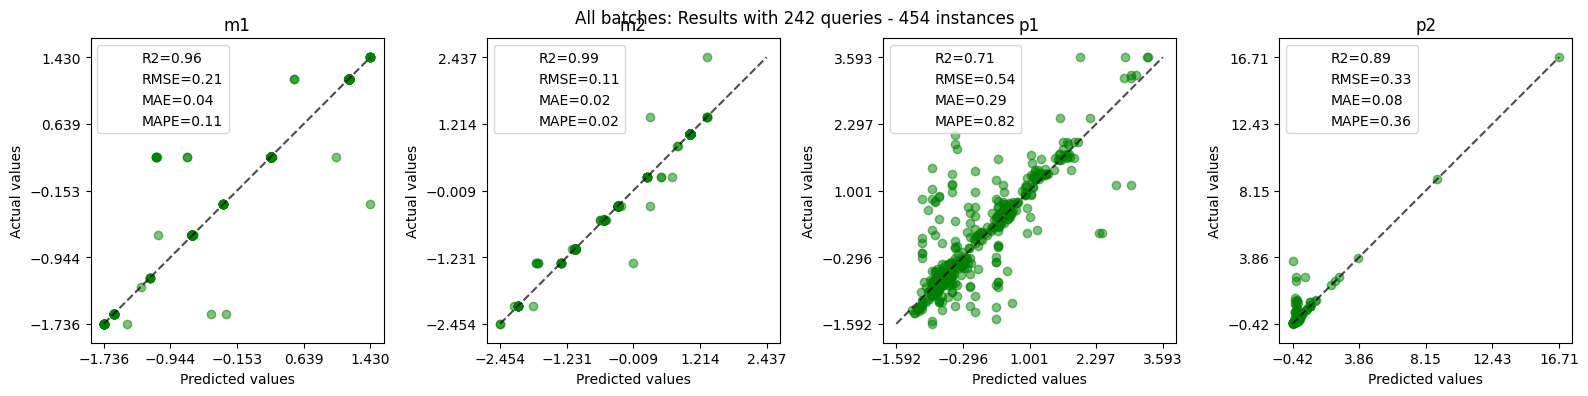

R2= 0.8864107303042605
MSE= 0.11358926969573949
RMSE= 0.3370300723907875
MAE= 0.10658466212076448
MAPE= 0.32813074138824705



,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE
0,incremental - batch 0,30,734,30,0.168955,0.814289,0.185711,0.430942,0.088427,0.151638
1,incremental - batch 1,424,734,212,3.699146,0.891514,0.108486,0.329373,0.107869,0.340618
2,incremental - all,454,734,242,6.996203,0.886411,0.113589,0.337030,0.106585,0.328131


time: 9.86 s (started: 2024-12-20 19:49:10 +00:00)


In [19]:
print ("STPLUS - tactics & embeddings")
target = OBJ_STPLUS
X, y, fnames = get_regression_data(df_stplus, target=target, tactics=True, embeddings=True, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

metrics, y_pred_ial_stplus = run_active_learning_batches(X, y, regressor, n_queries=0.5, calibration=True, show_plots=(1,4),
                                      target=target, verbose=False, show_errors=False, filename='stplus-incremental-all.pdf')

print()
pd.DataFrame(metrics)

Target: m1


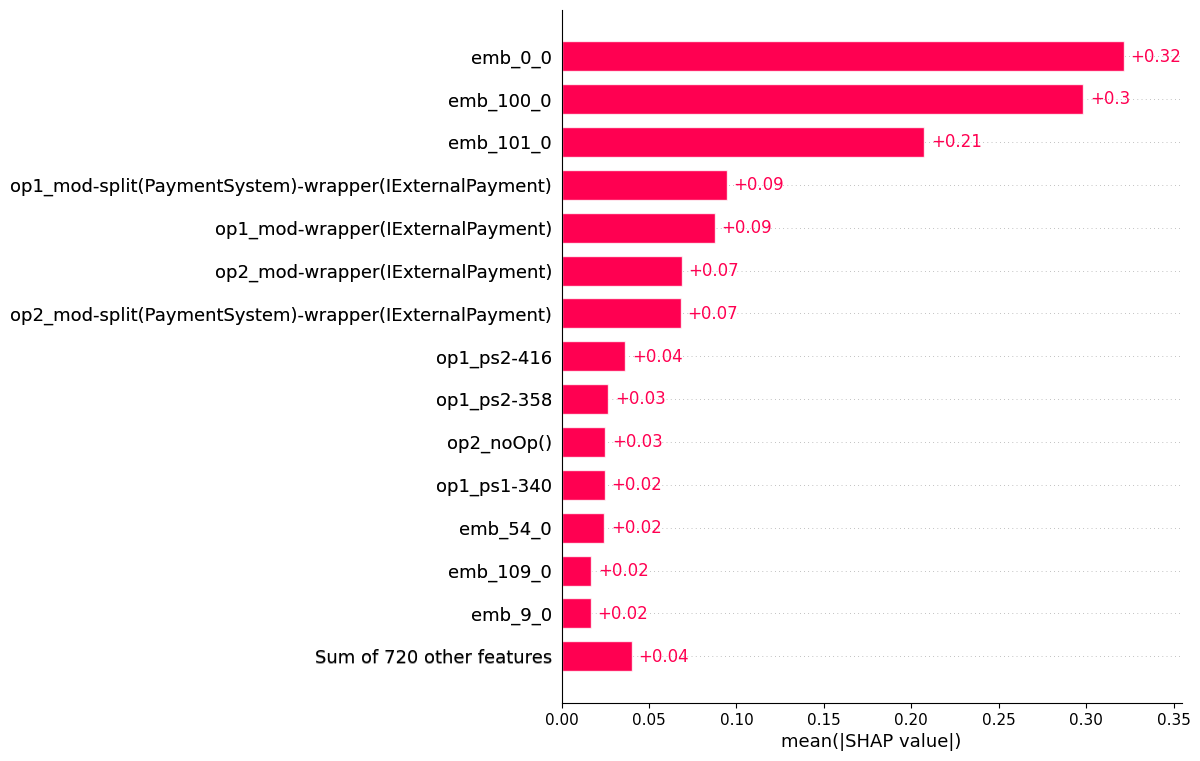

Target: m2


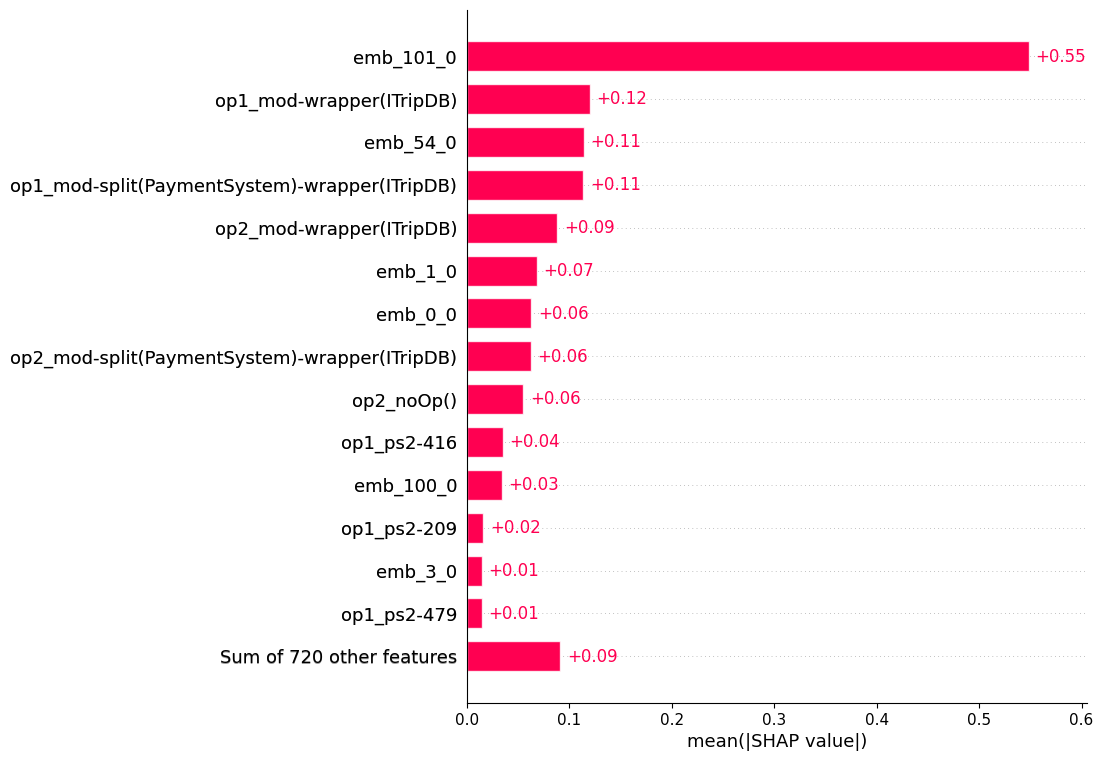

Target: p1


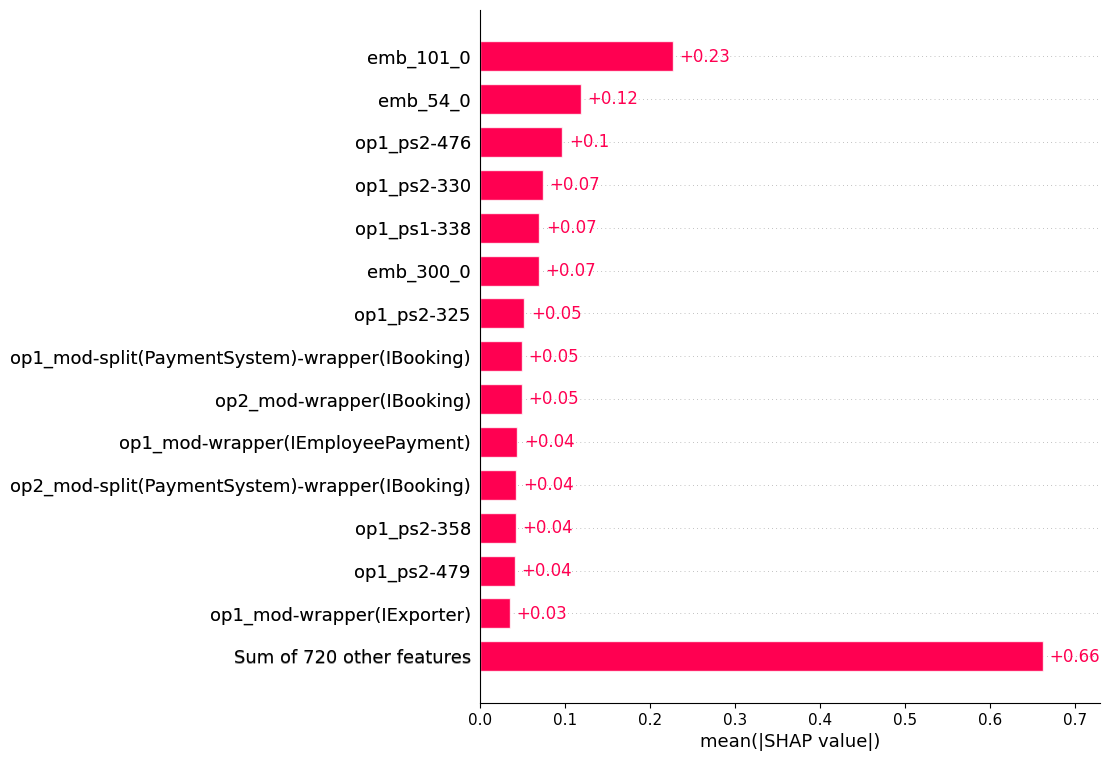

Target: p2


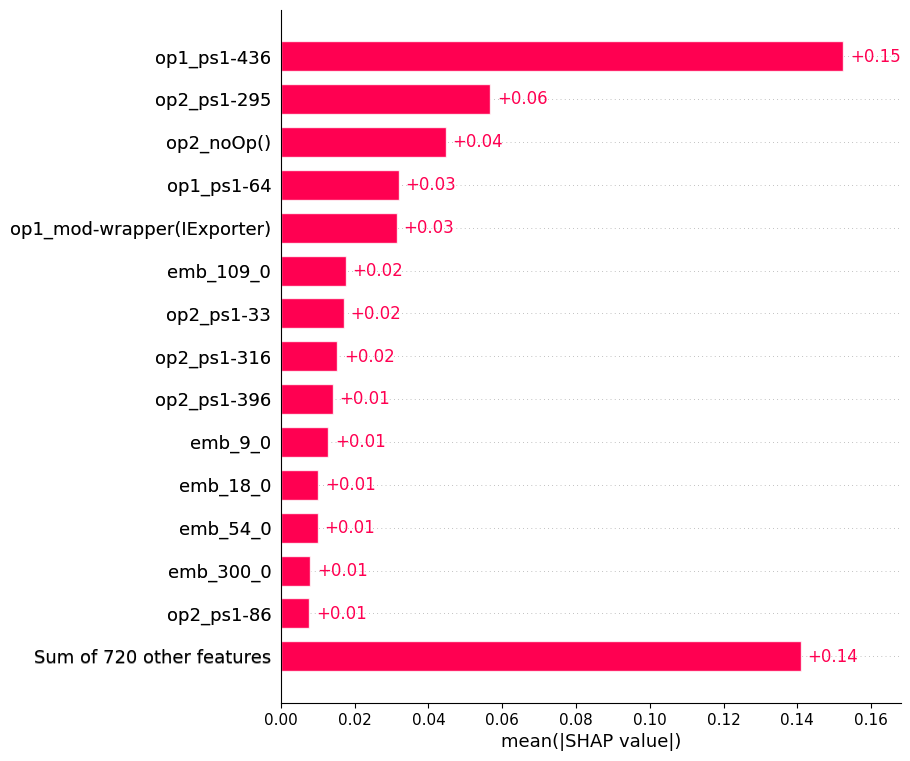

time: 2.74 s (started: 2024-12-20 19:49:20 +00:00)


In [20]:
Z = np.concatenate(X, axis=0)
show_shap_plots(Z, fnames, regressor, OBJ_STPLUS)

#### Experiments with different values of the SF parameter (n_queries)

In [21]:
print ("STPLUS - tactics & embeddings")
print()
target = OBJ_STPLUS

# This code snippet is designed to experiment with different values of the sampling
# fraction (SF), represented by the n_queries variable, in an active learning scenario
# for regression tasks. It focuses on the ST+ dataset and evaluates the performance
# of a machine learning model with varying sampling fractions.

df_list = []
preds_by_sf_stplus = dict()
for n in range(1,6): # Variation of the SF parameter
  print()
  print("-"*50)
  n_queries = n * 0.1
  print("n_queries:", n_queries)

  X, y, _ = get_regression_data(df_stplus, target=target, tactics=True, embeddings=True, split_by_level=True)

  regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
  regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
  regressor = regr_xgb # regr_rf # regr_xgb

  metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=n_queries, calibration=True, show_plots=None, target=target, verbose=False)
  df_metrics = pd.DataFrame(metrics)
  df_metrics['n_queries'] = n_queries
  df_list.append(df_metrics)
  preds_by_sf_stplus[n_queries] = y_pred

print()
print("="*10, "RESULTS STPLUS:")
df_metrics_stplus = pd.concat(df_list).reset_index(drop=True)
df_metrics_stplus

STPLUS - tactics & embeddings


--------------------------------------------------
n_queries: 0.1
standard scaling y ... 2
max 0.1 percentage - queries
Batch 0: (30, 734) (30, 4)
Batch 0: Initial training with 30 points - 30 instances
Regressor score=1.00 

Initial metrics:
R2= 0.8159679688769995
MSE= 0.18403203112300043
RMSE= 0.42898954663604616
MAE= 0.09194549248620278
MAPE= 0.10545624994927637

Batch  1 : (424, 734) (424, 4)
max 42 queries
Selecting indices at random!
0.1 42 queries: [54, 315, 359, 386, 333, 269, 126, 138, 376, 130, 149, 375, 37, 337, 230, 155, 238, 350, 203, 201, 398, 60, 134, 114, 161, 183, 413, 133, 184, 411, 323, 264, 76, 82, 282, 340, 339, 140, 84, 5, 35, 62]
Batch 1: Adjusted after 42 queries - 424 instances

Adjusted metrics:
R2= 0.3920121559081519
MSE= 0.607987844091848
RMSE= 0.7797357527341221
MAE= 0.3407058911434954
MAPE= 0.8486930914332356

Elapsed time: 3.7381884019999916 seconds

oracle evaluation: 72 (out of 454 points)
R2= 0.4200268572056531
MSE= 0.57

,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE,n_queries
0,incremental - batch 0,30,734,30,0.160472,0.815968,0.184032,0.428990,0.091945,0.105456,0.1
1,incremental - batch 1,424,734,42,3.557141,0.392012,0.607988,0.779736,0.340706,0.848693,0.1
2,incremental - all,454,734,72,3.738188,0.420027,0.579973,0.761560,0.324268,0.799581,0.1
3,incremental - batch 0,30,734,30,0.150297,0.736292,0.263708,0.513525,0.127525,0.172216,0.2
4,incremental - batch 1,424,734,85,4.186584,0.631495,0.368505,0.607046,0.225716,0.656844,0.2
5,incremental - all,454,734,115,4.355682,0.638420,0.361580,0.601315,0.219228,0.624820,0.2
6,incremental - batch 0,30,734,30,0.282857,0.782619,0.217381,0.466242,0.100052,0.175404,0.3
7,incremental - batch 1,424,734,127,4.622340,0.843765,0.156235,0.395266,0.142882,0.426816,0.3
8,incremental - all,454,734,157,4.927842,0.839724,0.160276,0.400344,0.140052,0.410203,0.3
9,incremental - batch 0,30,734,30,0.160174,0.841458,0.158542,0.398173,0.075837,0.175219,0.4


time: 22.4 s (started: 2024-12-20 19:49:23 +00:00)


In [22]:
# Summary of final results
df_metrics_stplus[df_metrics_stplus['exp']=='incremental - all']

,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE,n_queries
2,incremental - all,454,734,72,3.738188,0.420027,0.579973,0.761560,0.324268,0.799581,0.1
5,incremental - all,454,734,115,4.355682,0.638420,0.361580,0.601315,0.219228,0.624820,0.2
8,incremental - all,454,734,157,4.927842,0.839724,0.160276,0.400344,0.140052,0.410203,0.3
11,incremental - all,454,734,200,4.537649,0.871057,0.128943,0.359087,0.116617,0.362951,0.4
14,incremental - all,454,734,242,4.654522,0.879361,0.120639,0.347331,0.110716,0.336533,0.5


time: 50.8 ms (started: 2024-12-20 19:49:45 +00:00)


### **COCOME results**
Test the 3 available configurations for the encodings, using the IAL approach

In [23]:
print("COCOME - tactics only")
target = OBJ_COCOME
X, y, _ = get_regression_data(df_cocome, target=target, tactics=True, embeddings=False, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=0.25, calibration=True, show_plots=(2,4),
                                      target=target, verbose=False, show_errors=False)

print()
pd.DataFrame(metrics)

Output hidden; open in https://colab.research.google.com to view.

In [24]:
print("COCOME - embeddings only")
target = OBJ_COCOME
X, y, _ = get_regression_data(df_cocome, target=target, tactics=False, embeddings=True, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=0.25, calibration=True, show_plots=(2,4),
                                      target=target, verbose=False, show_errors=False)

print()
pd.DataFrame(metrics)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
print("COCOME - tactics & embeddings")
target = OBJ_COCOME
X, y, fnames = get_regression_data(df_cocome, target=target, tactics=True, embeddings=True, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

metrics, y_pred_ial_cocome = run_active_learning_batches(X, y, regressor, n_queries=0.5, calibration=True, show_plots=(2,4),
                                      target=target, verbose=False, show_errors=False, filename='cocome-incremental-all.pdf')

print()
pd.DataFrame(metrics)

Output hidden; open in https://colab.research.google.com to view.

Target: m1


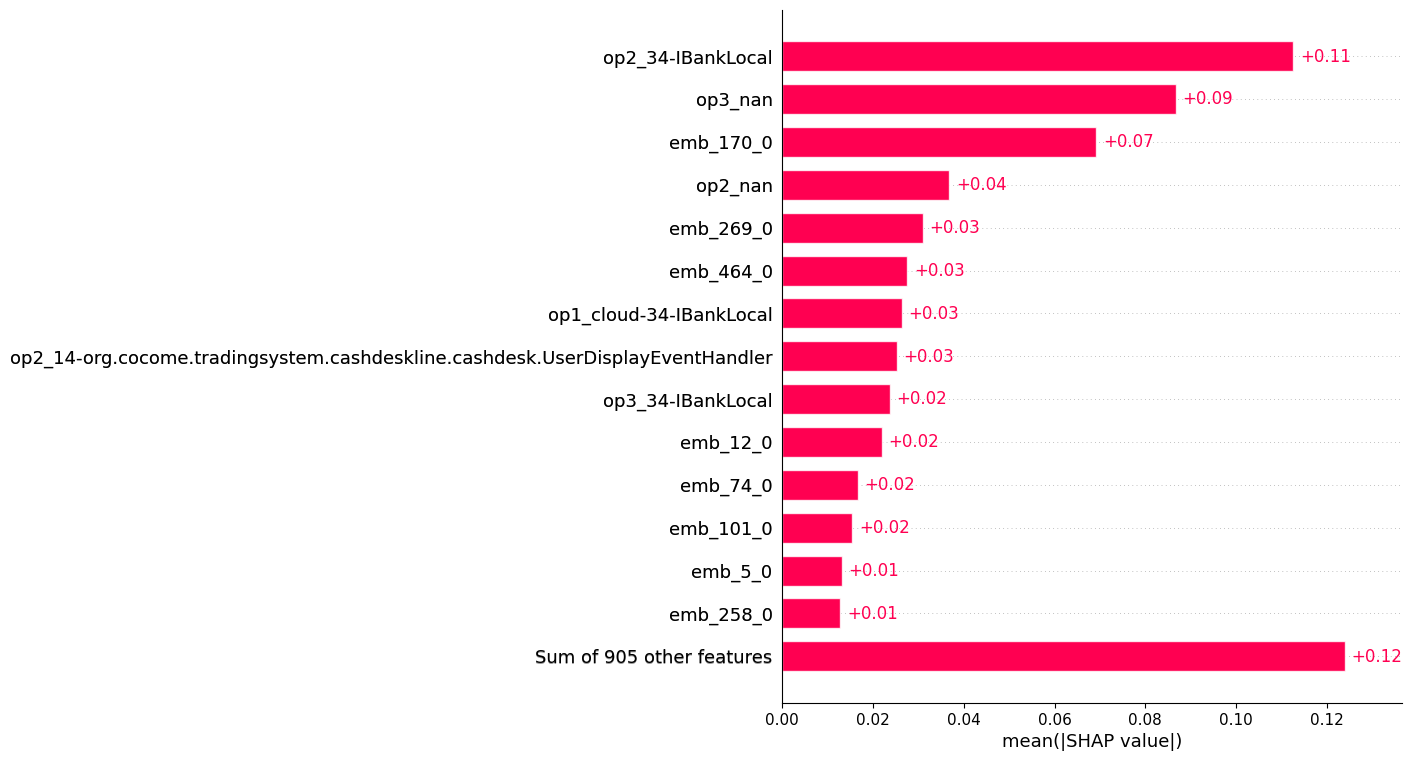

Target: m2


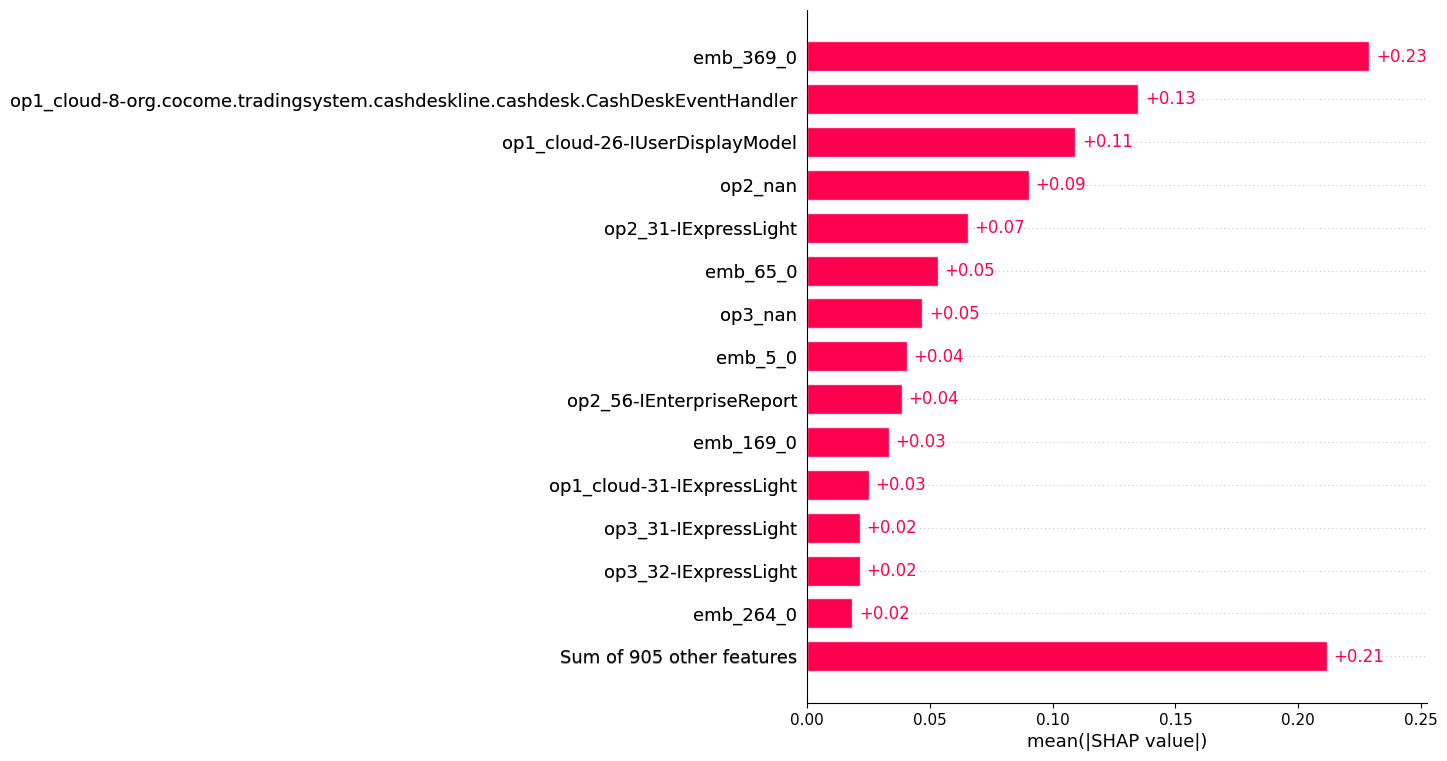

Target: m3


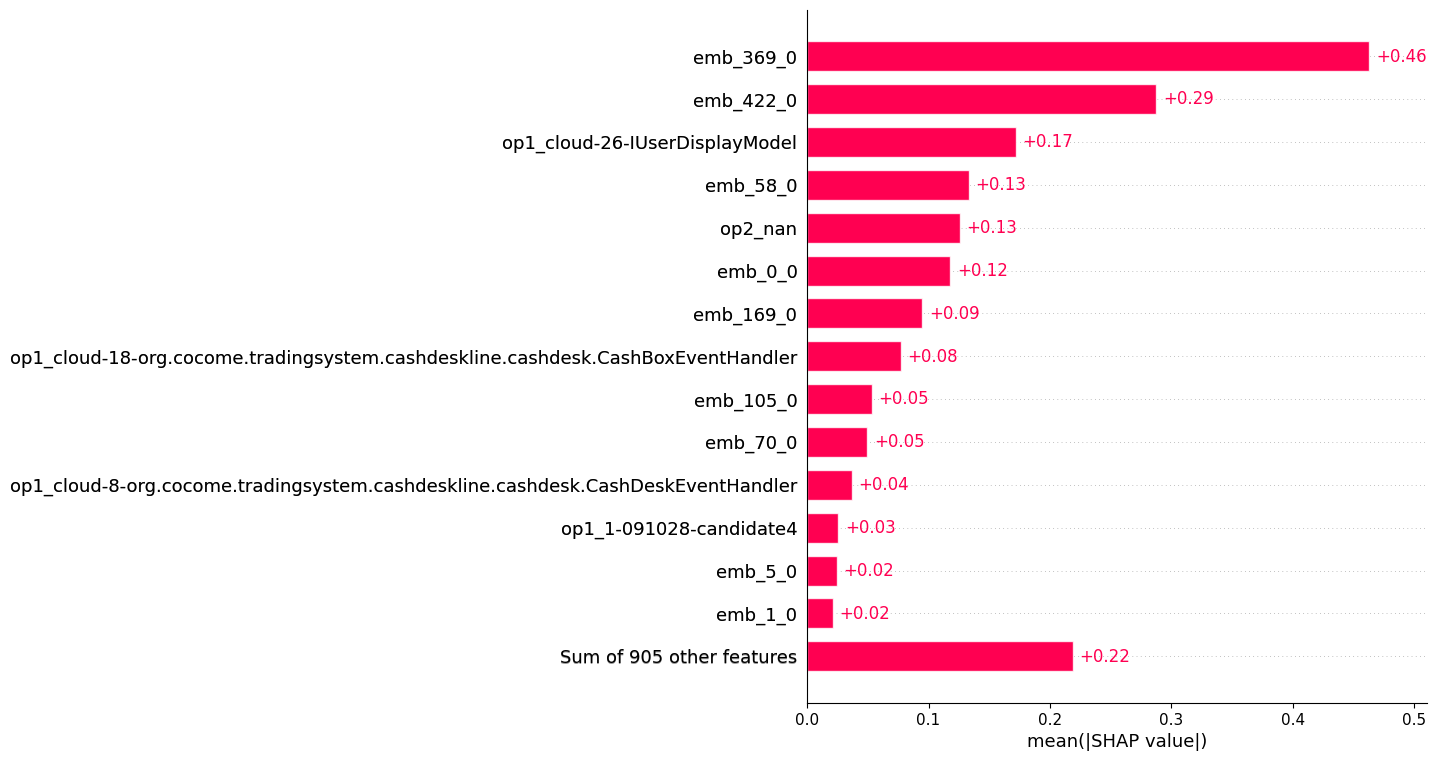

Target: m4


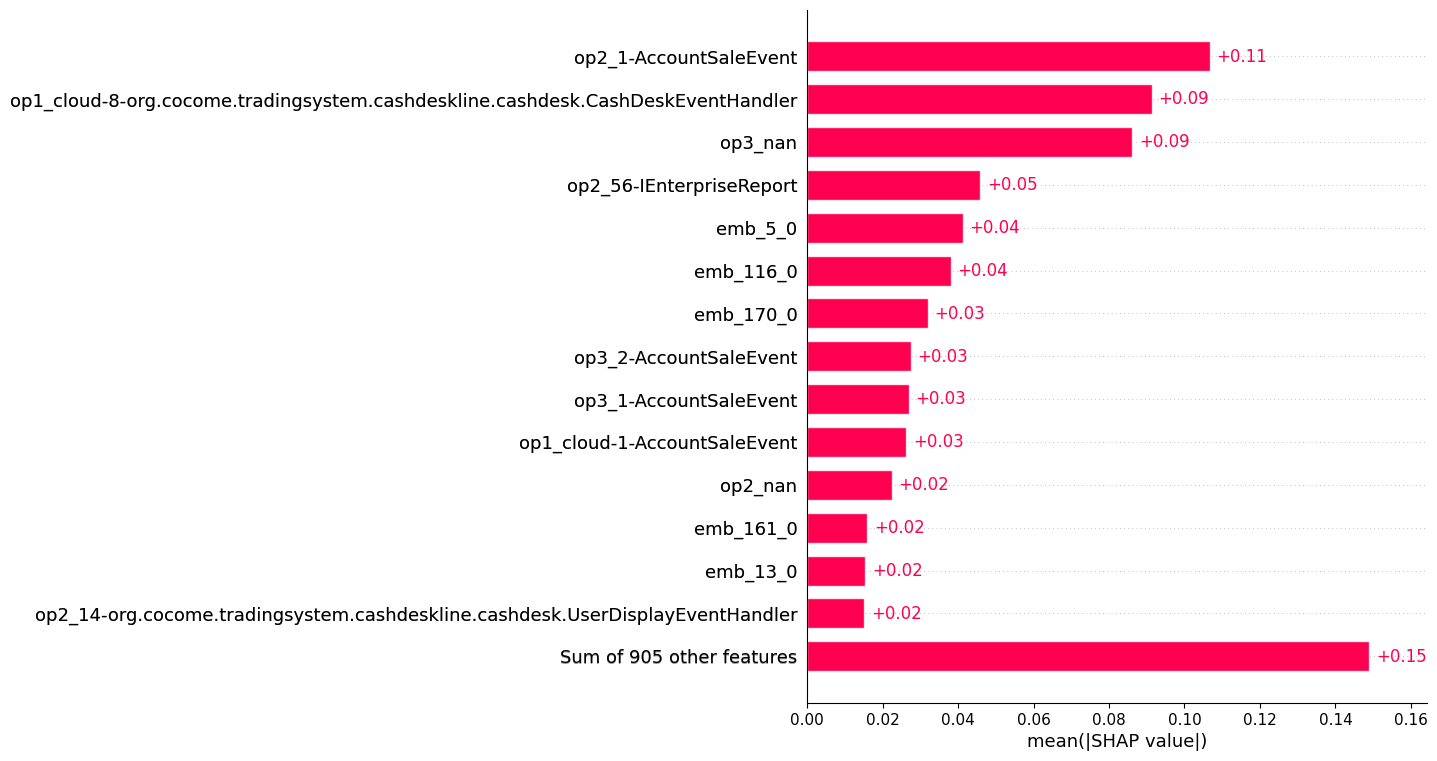

Target: p1


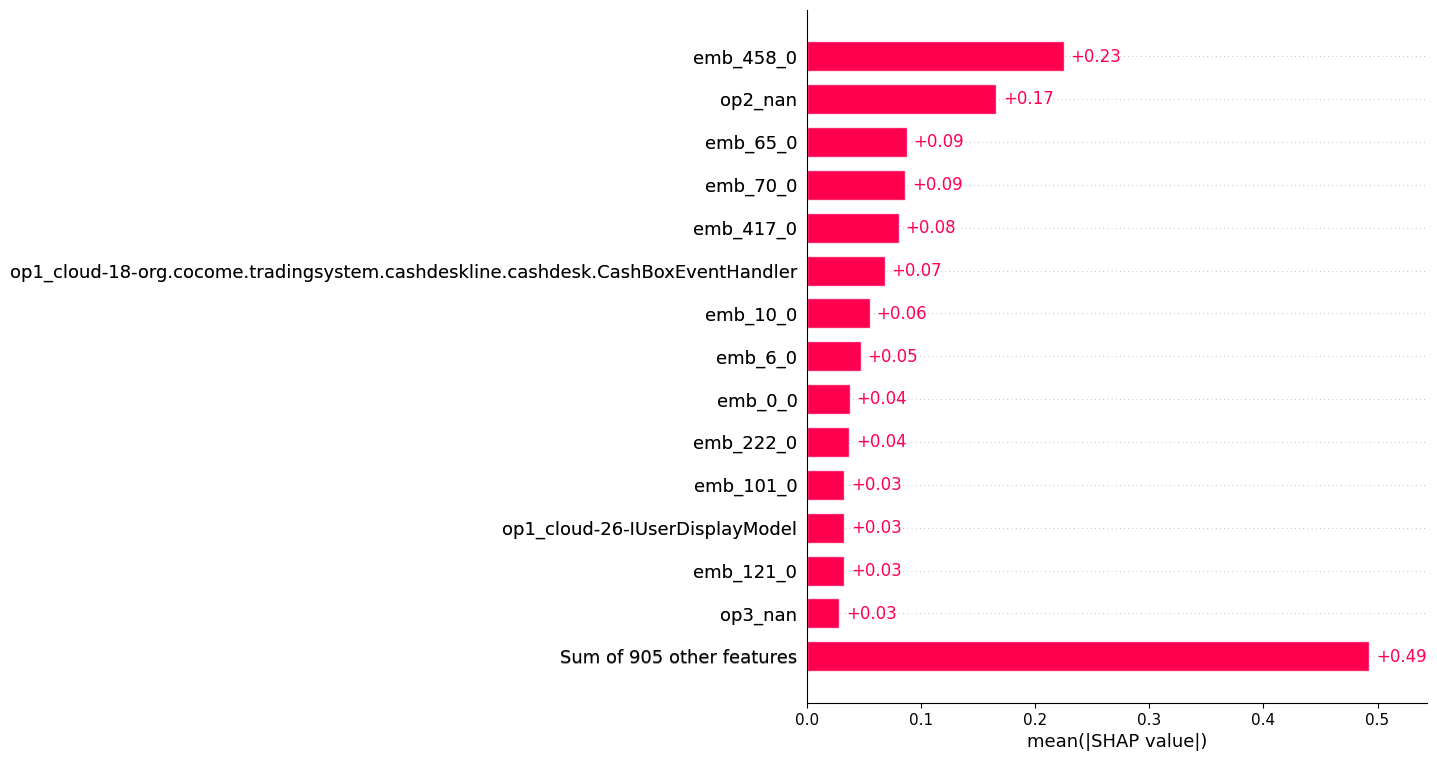

Target: p2


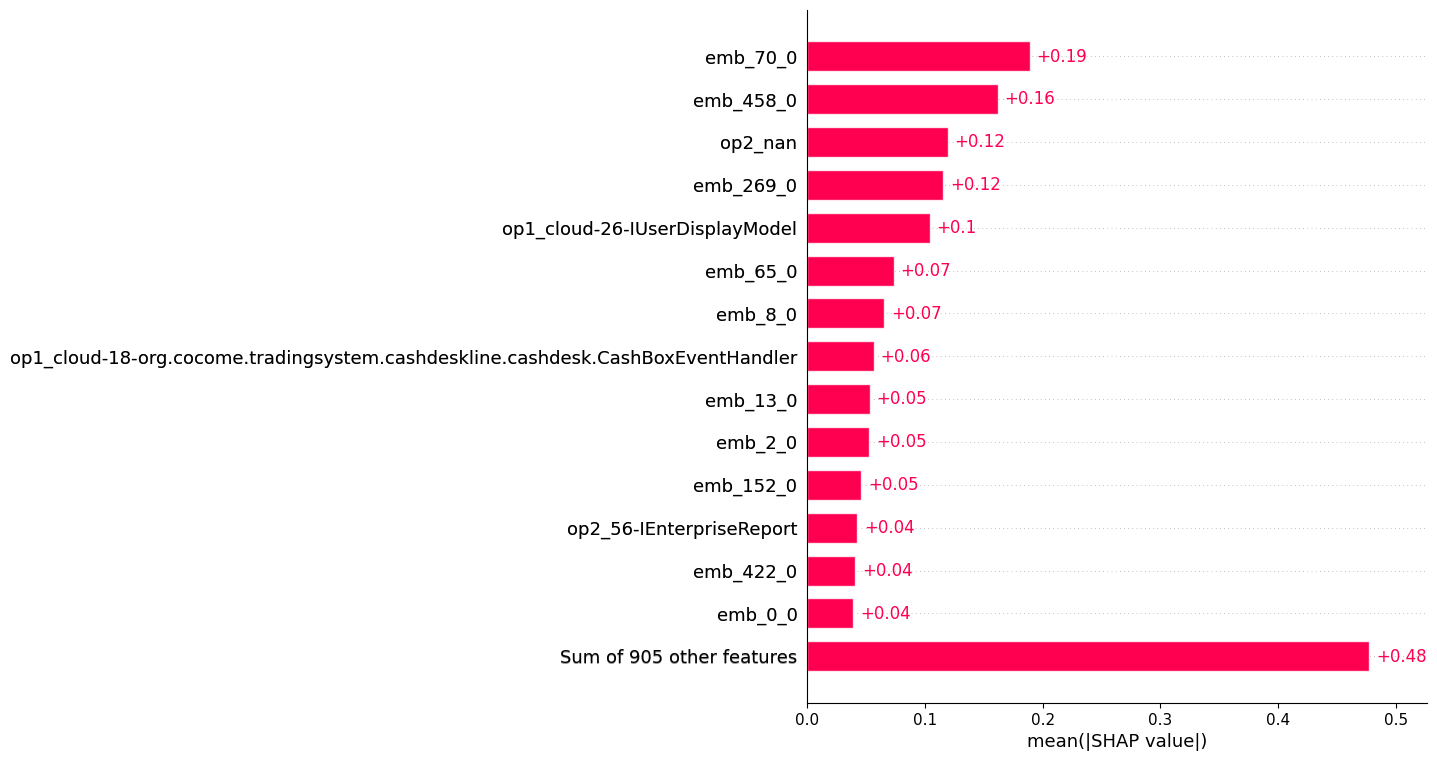

Target: p3


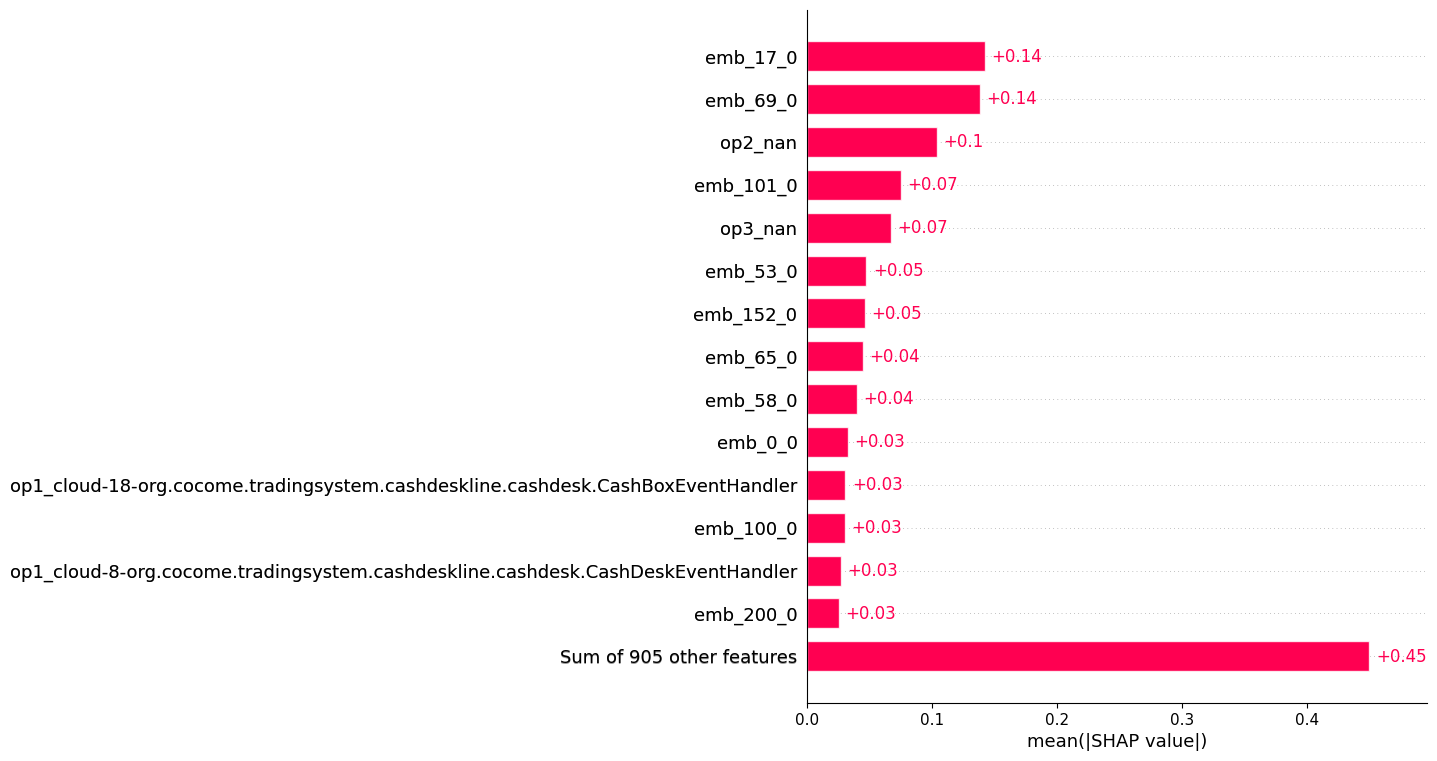

Target: p4


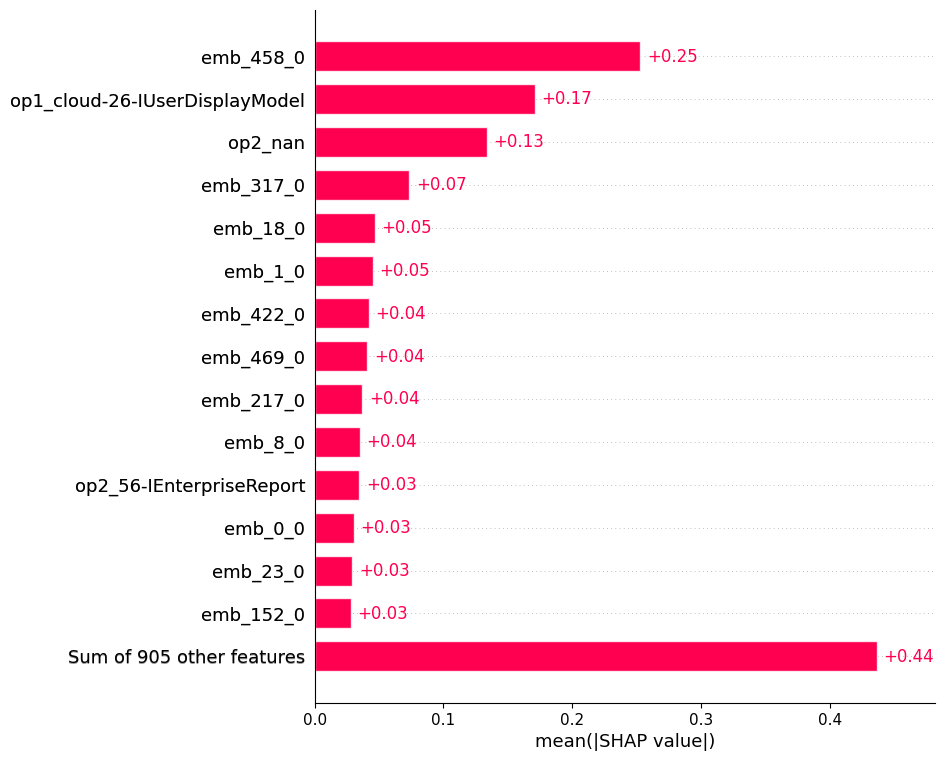

time: 9.27 s (started: 2024-12-20 19:52:55 +00:00)


In [26]:
Z = np.concatenate(X, axis=0)
show_shap_plots(Z, fnames, regressor, OBJ_COCOME)

#### Experiments with different values of the SF parameter (n_queries)

In [27]:
print ("COCOME")
print()
target = OBJ_COCOME

# This code snippet is designed to experiment with different values of the sampling
# fraction (SF), represented by the n_queries variable, in an active learning scenario
# for regression tasks. It focuses on the CoCoME dataset and evaluates the performance
# of a machine learning model with varying sampling fractions.

df_list = []
preds_by_sf_cocome = dict()
for n in range(1,6): # Variation of the SF parameter
  print()
  print("-"*50)
  n_queries = n * 0.1
  print("n_queries:", n_queries)

  X, y, _ = get_regression_data(df_cocome, target=target, tactics=True, embeddings=True, split_by_level=True)

  regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
  regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
  regressor = regr_xgb # regr_rf # regr_xgb

  metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=n_queries, calibration=True, show_plots=None, target=target, verbose=False)
  df_metrics = pd.DataFrame(metrics)
  df_metrics['n_queries'] = n_queries
  df_list.append(df_metrics)
  preds_by_sf_cocome[n_queries] = y_pred

print()
print("="*10, "RESULTS COCOME:")
df_metrics_cocome = pd.concat(df_list).reset_index(drop=True)
df_metrics_cocome

COCOME


--------------------------------------------------
n_queries: 0.1
standard scaling y ... 5
max 0.1 percentage - queries
Batch 0: (125, 919) (125, 8)
Batch 0: Initial training with 125 points - 125 instances
Regressor score=1.00 

Initial metrics:
R2= 0.5512641456277889
MSE= 0.44873585437221103
RMSE= 0.6698774920626988
MAE= 0.07818649968566391
MAPE= 1.283485573148758

Batch  1 : (344, 919) (344, 8)
max 34 queries
Selecting indices at random!
0.1 34 queries: [54, 315, 333, 269, 126, 138, 130, 149, 37, 337, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 323, 264, 76, 82, 282, 340, 339, 140, 84, 5, 35, 62]
Batch 1: Adjusted after 34 queries - 344 instances

Adjusted metrics:
R2= 0.16428446229450372
MSE= 0.8357155377054962
RMSE= 0.9141747850960976
MAE= 0.3116104331240166
MAPE= 1.037542823623183

Batch  2 : (301, 919) (301, 8)
max 30 queries
Selecting indices at random!
0.1 30 queries: [54, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133

,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE,n_queries
0,incremental - batch 0,125,919,125,0.647602,0.551264,0.448736,0.669877,0.078186,1.283486,0.1
1,incremental - batch 1,344,919,34,15.691006,0.164284,0.835716,0.914175,0.311610,1.037543,0.1
2,incremental - batch 2,301,919,30,16.015480,0.679638,0.320362,0.566006,0.095307,0.112944,0.1
3,incremental - batch 3,120,919,12,16.455591,0.202275,0.797725,0.893155,0.491922,2.613625,0.1
4,incremental - batch 4,302,919,30,17.840087,0.161403,0.838597,0.915750,0.411870,0.828125,0.1
5,incremental - all,1192,919,231,66.696487,0.338095,0.661905,0.813575,0.276066,0.935466,0.1
6,incremental - batch 0,125,919,125,0.662862,0.705303,0.294697,0.542860,0.054688,0.031688,0.2
7,incremental - batch 1,344,919,69,15.985679,0.181618,0.818382,0.904645,0.299987,0.941231,0.2
8,incremental - batch 2,301,919,60,16.879818,0.849177,0.150823,0.388360,0.052908,0.080438,0.2
9,incremental - batch 3,120,919,24,18.377936,0.387688,0.612312,0.782504,0.419322,1.408063,0.2


time: 6min 5s (started: 2024-12-20 19:53:05 +00:00)


In [28]:
# Summary of final results
df_metrics_cocome[df_metrics_cocome['exp']=='incremental - all']

,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE,n_queries
5,incremental - all,1192,919,231,66.696487,0.338095,0.661905,0.813575,0.276066,0.935466,0.1
11,incremental - all,1192,919,338,70.989174,0.443947,0.556053,0.745690,0.252906,0.594637,0.2
17,incremental - all,1192,919,445,72.005198,0.516388,0.483612,0.695422,0.245403,0.636324,0.3
23,incremental - all,1192,919,552,77.306337,0.588712,0.411288,0.641317,0.233612,0.588609,0.4
29,incremental - all,1192,919,658,78.070003,0.651903,0.348097,0.589997,0.217834,0.539427,0.5


time: 29.3 ms (started: 2024-12-20 19:59:10 +00:00)


In [31]:
df_metrics_stplus_all = df_metrics_stplus[df_metrics_stplus['exp']=='incremental - all']
df_metrics_stplus_all.to_csv('stplus-incremental-all.csv', index=False)

time: 12.2 ms (started: 2024-12-20 20:45:08 +00:00)


In [32]:
df_metrics_cocome_all = df_metrics_cocome[df_metrics_cocome['exp']=='incremental - all']
df_metrics_cocome_all.to_csv('cocome-incremental-all.csv', index=False)

time: 9.88 ms (started: 2024-12-20 20:45:33 +00:00)


---